In [1]:
import sys, os, pickle
from joblib import Parallel, delayed
import pandas as pd
from jumpmodels.utils import filter_date_range
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from jumpmodels.sparse_jump import SparseJumpModel
from sklearn.preprocessing import StandardScaler
from pypfopt.black_litterman import BlackLittermanModel, market_implied_prior_returns
from pypfopt.efficient_frontier import EfficientFrontier
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import exceptions 
from scipy.optimize import brentq
import cvxpy as cp
from scipy import stats

# sys.path.append('/Users/victor/Documents/thesis_vri_vp/vic_new')         # for mac
sys.path.append('C:\\Users\\victo\\git_new\\thesis_vri_vp\\vic_new')      # for windows
# sys.path.append('/Users/vlad/Desktop/git/Masters-Thesis-VRI-VP/vic_new')         # for mac vlad
from feature_set_v2 import MergedDataLoader 

In [2]:
# 0) Global parameters ------------------------------------------------------------------
REFIT_FREQ        = "ME"        
MIN_TRAINING_YEARS= 8
MAX_TRAINING_YEARS= 12
INITIAL_TRAIN_START = "2002-05-31"
test_start        = "2017-01-01"

# Pick method to drive backtest: "grid", "bayes" or "history" ---------------------------
cv_choice = "bayes"

# Paths & tickers -----------------------------------------------------------------------
script_dir = os.getcwd()
base_dir   = os.path.abspath(os.path.join(script_dir, "..", "..", "..","..", ".."))
data_dir   = os.path.join(base_dir, "data_new")

factor_file = os.path.join(data_dir, "1estimation_index_returns.csv")
market_file = os.path.join(data_dir, "1macro_data.csv")
etf_file    = os.path.join(data_dir, "2trading_etf_returns_aligned.csv")

factors = ["iwf", "mtum", "qual", "size", "usmv", "vlue"]   # used everywhere

# grid_df    = pd.read_parquet("cv_params_grid.parquet")
# bayes_df   = pd.read_parquet("cv_params_bayes_v2.parquet") # v2 is the one searching between 20-2000
# history_df = pd.read_parquet("cv_params_history.parquet")

In [3]:
# # ──────────────────────────────────────────────────────────────
# # HYPERPARAMETERS
# # ──────────────────────────────────────────────────────────────
# df_map = {
#     "grid":    grid_df,
#     "bayes":   bayes_df,
#     "history": history_df
# }
# cv_df = df_map[cv_choice]

# # ─────────────────────────────────────────────────────
# # HYPERPARAMETER SMOOTHING SETUP
# # ─────────────────────────────────────────────────────
# # pick one
# SMOOTH_METHOD = "none"   # options: "none", "rolling_median", "ewma"
# SMOOTH_WINDOW = 3        # # of folds to include in the window
# # ─────────────────────────────────────────────────────

# # … right after cv_df = df_map[cv_choice] …
# cv_df = cv_df.sort_values(["factor","date"])

# if SMOOTH_METHOD == "none":
#     # simply copy original λ & κ forward
#     cv_df["sm_lambda"] = cv_df["best_lambda"]
#     cv_df["sm_kappa"]  = cv_df["best_kappa"]

# elif SMOOTH_METHOD == "rolling_median":
#     # Centered rolling median
#     cv_df["sm_lambda"] = (
#         cv_df
#         .groupby("factor")["best_lambda"]
#         .transform(lambda x: x.rolling(SMOOTH_WINDOW, min_periods=1, center=True).median())
#     )
#     cv_df["sm_kappa"] = (
#         cv_df
#         .groupby("factor")["best_kappa"]
#         .transform(lambda x: x.rolling(SMOOTH_WINDOW, min_periods=1, center=True).median())
#     )

# elif SMOOTH_METHOD == "ewma":
#     # Exponential‐weight moving average
#     cv_df["sm_lambda"] = (
#         cv_df
#         .groupby("factor")["best_lambda"]
#         .transform(lambda x: x.ewm(span=SMOOTH_WINDOW, min_periods=1).mean())
#     )
#     cv_df["sm_kappa"] = (
#         cv_df
#         .groupby("factor")["best_kappa"]
#         .transform(lambda x: x.ewm(span=SMOOTH_WINDOW, min_periods=1).mean())
#     )

# else:
#     raise ValueError(f"Unknown SMOOTH_METHOD {SMOOTH_METHOD!r}")

# # round κ back to integer
# cv_df["sm_kappa"] = cv_df["sm_kappa"].round().astype(int)

# # overwrite with the chosen values
# cv_df["best_lambda"] = cv_df["sm_lambda"]
# cv_df["best_kappa"]  = cv_df["sm_kappa"]

# # (optional) drop helpers
# cv_df.drop(columns=["sm_lambda","sm_kappa"], inplace=True)

# # ─────────────────────────────────────────────────────
# # Now build saved_hyperparams exactly as before
# # ─────────────────────────────────────────────────────
# saved_hyperparams = {}
# for fac in factors:
#     sub = cv_df[cv_df["factor"] == fac].sort_values("date")
#     saved_hyperparams[fac] = [
#         {
#             "date":      row["date"],
#             "new_lambda": row["best_lambda"],
#             "new_kappa":  row["best_kappa"]
#         }
#         for _, row in sub.iterrows()
#     ]


In [4]:
# ──────────────────────────────────────────────────────────────
# DATA‑LOADING BLOCK  (pulled from old notebook)
# ──────────────────────────────────────────────────────────────

# 1) Load full data for every factor + market ------------------------------------------------
factor_data_dict  = {}
factor_returns_ls = []

for fac in factors:
    print(f"Loading data for {fac}")
    data = MergedDataLoader(
        factor_file=factor_file,
        market_file=market_file,
        ver="v2",
        factor_col=fac
    ).load()

    common_idx = (data.X.index
                  .intersection(data.ret_ser.index)
                  .intersection(data.market_ser.index))

    X_full        = data.X.loc[common_idx]
    fac_ret_full  = data.ret_ser.loc[common_idx]
    mkt_ret_full  = data.market_ser.loc[common_idx]
    active_ret    = fac_ret_full - mkt_ret_full

    factor_data_dict[fac] = {
        "X"        : X_full,
        "fac_ret"  : fac_ret_full,
        "mkt_ret"  : mkt_ret_full,
        "active_ret": active_ret,
    }
    factor_returns_ls.append(fac_ret_full)

# save last loop’s mkt_ret_full as market series
all_market_ret = mkt_ret_full

# 2) Assemble master return dataframe (factors + Market + rf) -------------------------------
full_factors_df = pd.concat(factor_returns_ls, axis=1).dropna()
full_df = pd.concat([full_factors_df, all_market_ret], axis=1).dropna()
full_df.columns = factors + ["Market"]

# risk‑free
etf_df   = pd.read_csv(etf_file, index_col=0, parse_dates=True).dropna().sort_index()
rf_ser   = etf_df["rf"]
full_df  = pd.concat([full_df, rf_ser], axis=1).dropna()
full_df.columns = factors + ["Market", "rf"]

# 3) Define test index (everything from 2017‑01‑01 on) --------------------------------------
test_slice = full_df.loc[test_start:]
test_index = test_slice.index.sort_values()
# ──────────────────────────────────────────────────────────────


Loading data for iwf
Loading data for mtum
Loading data for qual
Loading data for size
Loading data for usmv
Loading data for vlue


In [5]:
# ------------------------------------------------------------
# 1  BUILD & CACHE FACTOR‑VIEWS  (run once, takes minutes)
# ------------------------------------------------------------
VIEWS_FILE = "bayes_factor_views_v2_2014.pkl" # "SAVEfactor_views.pkl" is the views for the outperforming sharpe run
FORCE_REBUILD = False 

def _fit_one_factor(fac, refit_date, test_dates_chunk,
                    factor_data_dict, hyperparams,
                    min_years, max_years, init_start):

    # ---------- helpers ----------
    def get_train_window(current_date, full_data):
        train_end  = current_date
        train_start= max(train_end - pd.DateOffset(years=max_years),
                         pd.to_datetime(init_start))
        if (train_end - train_start) < pd.Timedelta(days=365.25*min_years):
            train_start = train_end - pd.DateOffset(years=min_years)
        idx = full_data.index
        subset = idx[(idx >= train_start) & (idx <= train_end)]
        start_date, end_date = subset.min(), subset.max()
        return start_date, end_date 

    # ---------- data ----------
    fac_data = factor_data_dict[fac]
    X   = fac_data["X"]
    ret = fac_data["fac_ret"]
    act = fac_data["active_ret"]

    lam = hyperparams["new_lambda"]
    kp  = hyperparams["new_kappa"]
    train_start, train_end = get_train_window(refit_date, X)

    # ---------- preprocess ----------
    clipper = DataClipperStd(mul=3.0)
    scaler  = StandardScaler()
    X_train = scaler.fit_transform(clipper.fit_transform(
                 filter_date_range(X, train_start, train_end)))
    active_train = filter_date_range(act, train_start, train_end)

    # ---------- fit SJM ----------
    sjm = SparseJumpModel(n_components=2,
                          max_feats=int(kp**2),
                          jump_penalty=lam)
    
    train_idx = filter_date_range(X, train_start, train_end).index
    X_train_df = pd.DataFrame(X_train, index=train_idx, columns=X.columns)
    sjm.fit(X_train_df, ret_ser=active_train, sort_by="cumret")

    ret_train = filter_date_range(ret, train_start, train_end)

    # regime‑level abs returns
    train_states = sjm.predict(X_train_df)
    abs_ret = {}
    for st in range(2):
        st_idx = (train_states==st)
        abs_ret[st] = ret_train.loc[st_idx].mean() * 252

    # ---------- online prediction for test dates ----------
    states = {}
    for day in test_dates_chunk:
        X_hist = X.loc[:day]                          # all history up to 'day'
        temp_clipper = DataClipperStd(mul=3.0)
        X_hist_clip  = temp_clipper.fit_transform(X_hist)

        temp_scaler  = StandardScaler()
        _ = temp_scaler.fit_transform(X_hist_clip)    # fit on *all* history

        if day in X.index:
            X_day_clip   = temp_clipper.transform(X.loc[[day]])
            X_day_scaled = temp_scaler.transform(X_day_clip)
            states[day]  = sjm.predict_online(
                pd.DataFrame(X_day_scaled,
                            index=[day],
                            columns=X.columns)).iloc[0]

    # assemble mini‑df for this factor & period
    out = pd.DataFrame({"state": pd.Series(states)},
                       index=list(states.keys()))
    out["ann_abs_ret"] = out["state"].map(abs_ret)
    return fac, out

def build_factor_views(factor_data_dict, saved_hyperparams, factors,
                       test_index,
                       refit_freq="ME", min_years=8, max_years=12,
                       init_start="2002-05-31"):

    views = {f:[] for f in factors}
    refit_dates = (test_index.to_series()
                   .resample(refit_freq)
                   .last()
                   .dropna())

    for j, refit_date in enumerate(refit_dates):
        if j < len(refit_dates)-1:
            next_refit = refit_dates.iloc[j+1]
        else:
            next_refit = test_index[-1]
        test_mask = (test_index>refit_date)&(test_index<=next_refit)
        test_chunk = test_index[test_mask]

        # ---- parallel over factors ----
        jobs = []
        for fac in factors:
            # latest hyperparams before refit_date
            hp_hist = [h for h in saved_hyperparams[fac]
                       if pd.to_datetime(h["date"])<=refit_date]
            if not hp_hist: continue
            hp = hp_hist[-1]
            jobs.append(delayed(_fit_one_factor)(
                fac, refit_date, test_chunk,
                factor_data_dict, hp,
                min_years, max_years, init_start))
        for fac, df in Parallel(n_jobs=-1)(jobs):
            views[fac].append(df)

    # concat & tidy
    for fac in factors:
        views[fac] = (pd.concat(views[fac])
                      .sort_index()
                      .loc[:,["state","ann_abs_ret"]])
    return views


# --------- build or load ----------         
if FORCE_REBUILD or not os.path.exists(VIEWS_FILE):
    factor_views = build_factor_views(factor_data_dict, saved_hyperparams, factors, 
                                      test_index,
                                      refit_freq=REFIT_FREQ, 
                                      min_years=8, max_years=12, init_start="2002-05-31")
    with open(VIEWS_FILE, "wb") as f:
        pickle.dump(factor_views, f)
else:
    with open(VIEWS_FILE, "rb") as f:
        factor_views = pickle.load(f)



In [6]:
for fac in factor_views:
    # 1) pull & sort your raw active return series
    daily_active = factor_data_dict[fac]["active_ret"].sort_index()

    # 2) build the expanding mean → annualized
    cum_mean_annual = daily_active.expanding().mean() * 252

    # 3) stick the raw active_ret into your factor_views DF
    factor_views[fac]["active_ret"] = (
        cum_mean_annual
        .reindex(factor_views[fac].index, method="ffill")
    )


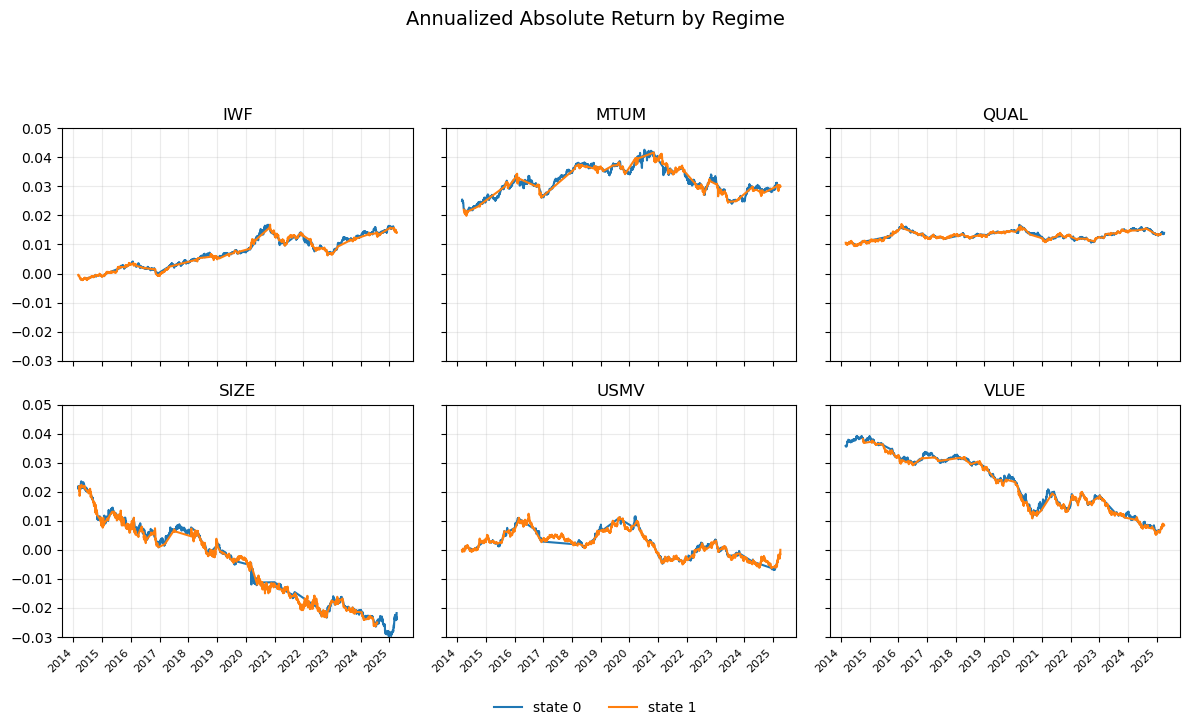

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math

facs = list(factor_views.keys())
n, cols = len(facs), 3
rows = math.ceil(n/cols)

fig, axes = plt.subplots(rows, cols,
                         figsize=(cols*4, rows*3.5),
                         sharex=True, sharey=True)

for ax, fac in zip(axes.flatten(), facs):
    df = factor_views[fac]
    for state, col, lbl in zip(
        [0,1], ['tab:blue','tab:orange'], ['state 0','state 1']
    ):
        sel = df['state'].eq(state)
        ax.plot(df.index[sel], df.loc[sel,'active_ret'],
                color=col, lw=1.5, label=lbl)
    ax.set_title(fac.upper(), fontsize=12)
    ax.set_ylim(-0.03, 0.05)
    ax.grid(alpha=0.25)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# rotate & align all x-labels    
for ax in axes.flatten():
    plt.setp(ax.xaxis.get_majorticklabels(),
             rotation=45, ha='right', fontsize=8)

# drop unused subplots
for ax in axes.flatten()[n:]:
    fig.delaxes(ax)

# single legend below
handles, labels = axes.flatten()[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='lower center',
           ncol=2, frameon=False, fontsize=10)

fig.suptitle('Annualized Absolute Return by Regime', fontsize=14, y=1.02)
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


In [8]:
# ------------------------------------------------------------
# 2  FAST BLACK‑LITTERMAN FUNCTION  (run as often as you like)
# ------------------------------------------------------------

def ewm_covariance(returns, halflife=126, min_periods=60):
    ewm_cov = returns.ewm(halflife=halflife,
                          adjust=False,
                          min_periods=min_periods).cov()
    if returns.empty: return pd.DataFrame()
    return ewm_cov.loc[returns.index[-1]]

def detect_state_shifts(views, factors):
    # 1 col per factor with the model‑state
    state_df = pd.concat({f: views[f]["state"] for f in factors}, axis=1)
    # True when *any* factor changes state vs. the day before
    return state_df.ne(state_df.shift()).any(axis=1)

# ---------- helper: dict -> (P,Q) for relative views ----------
def make_relative_views(view_dict, assets, benchmark="Market"):
    """
    Convert {'fac': active_ret, ...} into (P,Q) so that
    E[fac] - E[benchmark] = active_ret  for every factor.
    """
    if benchmark not in assets:
        raise ValueError(f"Benchmark {benchmark!r} not in trade universe")

    n = len(assets)
    k = len(view_dict)
    P = np.zeros((k, n))
    Q = np.zeros(k)

    for i, (fac, v) in enumerate(view_dict.items()):
        if fac not in assets:
            continue                      # ignore missing factors
        P[i, assets.index(fac)]       = 1
        P[i, assets.index(benchmark)] = -1
        Q[i] = v                       # the expected active return
    return P, Q


def bl_max_sharpe_te(cov_hist, pi, views, tau, delta,
                     w_bmk, te_target, bounds, rf,
                     use_bl_cov=False):

    P, Q = make_relative_views(views, list(w_bmk.index), benchmark="Market")
    bl   = BlackLittermanModel(cov_hist, pi=pi, tau=tau,
                           delta=delta, P=P, Q=Q)

    # pick the risk matrix
    Sigma = bl.bl_cov().values if use_bl_cov else cov_hist.values
    mu    = bl.bl_returns().values
    n     = len(mu)

    w = cp.Variable(n)
    w_act = w - w_bmk.values

    prob = cp.Problem(
        cp.Maximize((mu - rf) @ w),
        [
            cp.sum(w) == 1,
            w >= np.array([lo for lo, hi in bounds]),
            w <= np.array([hi for lo, hi in bounds]),
            cp.quad_form(w_act, Sigma) <= te_target**2
        ]
    )
    prob.solve(solver="SCS")
    return pd.Series(w.value, index=w_bmk.index)


def run_bl_with_drift(views, returns_df, full_df,
                      shift_series=None,
                      tau=0.05, delta=2.5,
                      te_target=0.05,
                      trade_market=True,
                      use_bl_cov=False,
                      allow_market_short=False,
                      allow_factor_short=False,
                      use_bl_prior=False,
                      fallback_strategy="HOLD_RFR",
                      tcost=0.0007,
                      initial_capital=1_000_000):
    """
    Returns:
      w_view   -> DataFrame of *target* weights from the optimizer
      w_actual -> DataFrame of *actual* daily weights, drifting unless rebalance
      rets     -> Series of daily portfolio returns (in decimal, e.g. 0.01 = 1%)
    """

    assets  = returns_df.columns.tolist()
    factors = list(views.keys())

    # Decide which assets can be traded
    if trade_market:
        trade_assets = [a for a in assets if a != "rf"]
    else:
        trade_assets = [a for a in assets if a not in {"rf", "Market"}]

    cash_asset = "rf"

    # Bounds
    bounds = []
    for a in trade_assets:
        if a == "Market":
            bounds.append((-.3, .3) if allow_market_short else (0, 0.3))
        else:
            bounds.append((-.3, .3) if allow_factor_short else (0, 0.3))

    # Prepare DataFrames
    w_view   = pd.DataFrame(0.0, index=returns_df.index, columns=trade_assets + [cash_asset], dtype=float)
    w_actual = pd.DataFrame(0.0, index=returns_df.index, columns=trade_assets + [cash_asset], dtype=float)

    # Track positions in “dollar” terms
    positions = pd.Series(0.0, index=trade_assets + [cash_asset])
    capital   = initial_capital

    # Series of daily returns, e.g. +0.005 = +0.5%
    rets = pd.Series(0.0, index=returns_df.index)

    for i, t in enumerate(returns_df.index):
        old_capital = capital  # Store capital before today’s returns

        # 1) Realize today's P&L from yesterday’s positions
        if i > 0:
            day_ret = returns_df.loc[t, trade_assets + [cash_asset]]
            daily_pnl = (positions[trade_assets] * day_ret[trade_assets]).sum() \
                        + positions[cash_asset] * day_ret[cash_asset]

            capital += daily_pnl
            # convert P&L → daily return = P&L / yesterday’s capital
            rets.loc[t] = daily_pnl / old_capital

        # 2) Decide if we rebalance today
        do_rebalance = False
        if i == 0:
            do_rebalance = True
        elif shift_series is not None and shift_series.loc[t]:
            do_rebalance = True

        # 3) If rebalancing, solve for new “view” weights
        if do_rebalance:
            hist = full_df[trade_assets].loc[:t].iloc[:-1]
            cov  = ewm_covariance(hist) * 252

            if cov.empty or cov.isna().any().any():
                w_view.loc[t, trade_assets] = 0.0
                w_view.loc[t, cash_asset]   = 1.0  # 100% cash
            else:
                # Build a quick "light" BlackLittermanModel
                if use_bl_prior:
                    market_caps  = {etf: 1.0 for etf in trade_assets}
                    prior_for_bl = market_implied_prior_returns(market_caps, delta, cov)
                else:
                    prior_for_bl = "equal"

                q = {fac: views[fac].loc[t, "active_ret"] for fac in factors}
                rf_annual = returns_df.loc[t, cash_asset] * 252

                # Build a quick "light" BlackLittermanModel
                q_abs = {fac: views[fac].loc[t, "ann_abs_ret"] for fac in factors}

                bl0 = BlackLittermanModel(
                    cov,
                    pi=prior_for_bl,
                    tau=tau,
                    delta=delta,
                    absolute_views=q_abs
)

                # 2) Check fallback if all implied returns ≤ rf
                if (
                    fallback_strategy != "NO_FALLBACK"
                    and (bl0.bl_returns() <= rf_annual).all()
                ):
                    # “Risk-off” scenario
                    w_view.loc[t, trade_assets] = 0.0  # all 0
                    if fallback_strategy == "HOLD_RFR":
                        w_view.loc[t, cash_asset] = 1.0  # 100% in cash
                    elif fallback_strategy == "SHORT_MARKET" and "Market" in trade_assets:
                        w_view.loc[t, "Market"]   = -1.0
                        w_view.loc[t, cash_asset] = 1.0
                    # skip the main BL max-sharpe
                else:
                    # normal BL
                    w_opt = bl_max_sharpe_te(
                        cov,
                        pi=prior_for_bl,
                        views=q,
                        tau=tau,
                        delta=delta,
                        w_bmk=pd.Series(1 / len(trade_assets), index=trade_assets),
                        te_target=te_target,
                        bounds=bounds,
                        rf=rf_annual,
                        use_bl_cov=use_bl_cov
                    )
                    w_view.loc[t, trade_assets] = w_opt
                    w_view.loc[t, cash_asset]   = 1 - w_opt.sum()


            # 4) Convert new “view weights” → actual $ positions
            new_positions = capital * w_view.loc[t]

            # transaction cost
            if tcost > 0 and i > 0:
                trades = (new_positions - positions).abs().sum()
                cost   = trades * tcost
                capital -= cost
                if capital > 0:
                    new_positions = capital * w_view.loc[t]

            positions = new_positions

        else:
            # Not rebalancing → copy forward yesterday’s “view” weights
            if i > 0:
                w_view.loc[t] = w_view.iloc[i - 1]

        # 5) Actual weights
        if capital > 0:
            w_actual.loc[t] = positions / capital
        else:
            w_actual.loc[t] = 0.0

    return w_view, w_actual, rets


In [10]:
# ------------------------------------------------------------
# 3  QUICK EXPERIMENTS
# ------------------------------------------------------------
def annualized_sharpe(r):          # helper
    return (r.mean() / r.std()) * np.sqrt(252)

def ann_turnover(w):
    daily_turn = w.diff().abs().sum(axis=1).mean()
    return daily_turn * 252

test_df = full_df.loc[test_index]
shift_days = detect_state_shifts(factor_views, factors).reindex(test_df.index, fill_value=False)
shift_days.iloc[0] = True

cfgs = [
    # these are the standard BL cov and BL prior - trading daily
    #  dict(label="Daily trades - 15% TE",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.15),
    #  dict(label="Daily trades - 5% TE",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.05),
    #  dict(label="Daily trades - 4% TE",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.04),
    #  dict(label="Daily trades - 3% TE",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.03),
    # dict(label="Daily trades - 2% TE",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.02),     
    #  dict(label="Daily trades - 1% TE",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.01),

    #  dict(label="Daily trades - 15% TE - mktshort",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=True, allow_factor_short=False, te_target=0.15), 
    #  dict(label="Daily trades - 5% TE - mktshort",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=True, allow_factor_short=False, te_target=0.05),
    #  dict(label="Daily trades - 4% TE - mktshort",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=True, allow_factor_short=False, te_target=0.04), 
    #  dict(label="Daily trades - 3% TE - mktshort",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=True, allow_factor_short=False, te_target=0.03),
    #  dict(label="Daily trades - 2% TE - mktshort",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=True, allow_factor_short=False, te_target=0.02), 
    #  dict(label="Daily trades - 1% TE - mktshort",  tau=0.05, delta=2.5, shift_series=None, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=True, allow_factor_short=False, te_target=0.01),
      

    # standard BL cov and BL prior trading only on shifts
    #  dict(label="Shifts - 15% TE",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.15),  
    #  dict(label="Shifts - 5% TE",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.05),
    #  dict(label="Shifts - 4% TE",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.04),
    #  dict(label="Shifts - 3% TE",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.03),
    #  dict(label="Shifts - 2% TE",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.02),
    #  dict(label="Shifts - 1% TE",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.01),

    # standard BL cov and BL prior trading only on shifts and allowing market shorts
    #  dict(label="Shifts - 15% TE - mktshort",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=True, allow_factor_short=False, te_target=0.15), 
    #  dict(label="Shifts - 5% TE - mktshort",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=True, allow_factor_short=False, te_target=0.05),
    #  dict(label="Shifts - 4% TE - mktshort",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=True, allow_factor_short=False, te_target=0.04),
    #  dict(label="Shifts - 3% TE - mktshort",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=True, allow_factor_short=False, te_target=0.03),
    #  dict(label="Shifts - 2% TE - mktshort",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=True, allow_factor_short=False, te_target=0.02),
    #  dict(label="Shifts - 1% TE - mktshort",  tau=0.05, delta=2.5, shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=True, allow_market_short=True, allow_factor_short=False, te_target=0.01),
    

    # Various set ups
    #  dict(label="Neither BL prior/cov - shifts 15%",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.15),
    #  dict(label="Neither BL prior/cov - shifts 3%",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.03),
    #  dict(label="Neither BL prior/cov - daily 15%",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.15),
    #  dict(label="Neither BL prior/cov - daily 3%",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.03),
    

    #  dict(label="+BL cov -BL prior - shifts - 15TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.15), 
    #  dict(label="+BL cov -BL prior - shifts - 5TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.05), 
    #  dict(label="+BL cov -BL prior - shifts - 4TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.04),
    #  dict(label="+BL cov -BL prior - shifts - 3TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.03), 
    #  dict(label="+BL cov -BL prior - shifts - 2TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.02),
    #  dict(label="+BL cov -BL prior - shifts - 1TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
    #      use_bl_cov=True, use_bl_prior=False, allow_market_short=False, allow_factor_short=False, te_target=0.01), 

    #  dict(label="Base model 15% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.15, fallback_strategy="NO_FALLBACK"),
    #  dict(label="Base model 5% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.05, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 4% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.04, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 3% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.03, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 2% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.02, fallback_strategy="NO_FALLBACK"),
    dict(label="Base model 1% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.01, fallback_strategy="NO_FALLBACK"),    

    #  dict(label="L/S 15% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.15, fallback_strategy="NO_FALLBACK"),
    #  dict(label="L/S 5% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.05, fallback_strategy="NO_FALLBACK"),
     dict(label="L/S 4% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.04, fallback_strategy="NO_FALLBACK"),
     dict(label="L/S 3% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.03, fallback_strategy="NO_FALLBACK"),
     dict(label="L/S 2% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.02, fallback_strategy="NO_FALLBACK"),
    dict(label="L/S 1% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.01, fallback_strategy="NO_FALLBACK"),      

    #  dict(label="Risk-off 15% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.15, fallback_strategy="HOLD_RFR"),
    #  dict(label="Risk-off 5% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.05, fallback_strategy="HOLD_RFR"),
     dict(label="Risk-off 4% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.04, fallback_strategy="HOLD_RFR"),
     dict(label="Risk-off 3% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.03, fallback_strategy="HOLD_RFR"),
     dict(label="Risk-off 2% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.02, fallback_strategy="HOLD_RFR"),
    dict(label="Risk-off 1% TE",  tau=0.05, delta=2.5,shift_series=shift_days, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.01, fallback_strategy="HOLD_RFR"),

]


run_results = {}
for c in cfgs:
    label = c.pop("label")
    w_view, w_act, daily_returns = run_bl_with_drift(
        factor_views,  # factor views
        test_df,       # returns_df
        full_df,       # full_df
        **c
    )
    
    run_results[label] = {
        "returns":        daily_returns,  # decimal daily returns
        "weights_view":   w_view,
        "weights_actual": w_act,
        "cfg":            c
    }
 




In [11]:
import pickle

# # # 1) After your loop finishes, save it:
with open("run_results.pkl", "wb") as f:
    pickle.dump(run_results, f)



# # 2) Load it back in one line:
# with open("run_results.pkl", "rb") as f:
#     run_results = pickle.load(f)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import SelectMultiple, Dropdown, ToggleButtons, VBox, HBox, interact

import importlib, jumpmodels.plot as jmplot
importlib.reload(jmplot)
from jumpmodels.plot import plot_cumret_compounded

# === Cleaner labels ===
strategy_labels = {
    "Benchmark (Q-Rebalanced EW)": "Benchmark (Q-Rebalanced EW)",
    "Benchmark (Market Buy-Hold)": "Benchmark (Market Buy-Hold)",
    "Base model 1% TE": "Dynamic Allocation (1 per cent TE)",
    "Base model 2% TE": "Dynamic Allocation (2 per cent TE)",
    "Base model 3% TE": "Dynamic Allocation (3 per cent TE)",
    "Base model 4% TE": "Dynamic Allocation (4 per cent TE)",
    "L/S 1% TE": "Dynamic Long-Short Allocation (1 per cent TE)",
    "L/S 2% TE": "Dynamic Long-Short Allocation (2 per cent TE)",
    "L/S 3% TE": "Dynamic Long-Short Allocation (3 per cent TE)",
    "L/S 4% TE": "Dynamic Long-Short Allocation (4 per cent TE)",
    "Risk-off 1% TE": "Dynamic Allocation with Risk-Off (1 per cent TE)",
    "Risk-off 2% TE": "Dynamic Allocation with Risk-Off (2 per cent TE)",
    "Risk-off 3% TE": "Dynamic Allocation with Risk-Off (3 per cent TE)",
    "Risk-off 4% TE": "Dynamic Allocation with Risk-Off (4 per cent TE)",
}

run_results = {
    strategy_labels.get(orig, orig): vals
    for orig, vals in run_results.items()
}

factor_labels = {
    "iwf":  "IWF (Growth factor)",
    "mtum": "MTUM (Momentum factor)",
    "qual": "QUAL (Quality factor)",
    "size": "SIZE (Size factor)",
    "usmv": "USMV (Low-volatility factor)",
    "vlue": "VLUE (Value factor)",
    "Market": "Market",
    "rf":     "Risk-free"
}


# --------------------------------------------------------------------
# 1) Clean out old EW from run_results
# --------------------------------------------------------------------
for k in list(run_results):
    if k.startswith("Benchmark (Q-Rebalanced EW)"):
        run_results.pop(k)

# --------------------------------------------------------------------
# 2) Rebuild the EW benchmark for your test set
# --------------------------------------------------------------------
TCOST = 0.0007
df    = etf_df.loc[test_index.intersection(etf_df.index)].drop(columns=["rf"])
n     = df.shape[1]

# Quarter-end dates
first = df.index[0]
qends = df.index.to_series().resample("QE").last().dropna().index
if first not in qends:
    qends = qends.insert(0, first)

ew_rets    = pd.Series(index=df.index, dtype=float)
ew_weights = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)
prev_w     = np.zeros(n)

for i in range(len(qends) - 1):
    start, end = qends[i], qends[i + 1]
    period = df.loc[(df.index > start) & (df.index <= end)]
    w      = np.ones(n) / n
    for j, day in enumerate(period.index):
        ew_weights.loc[day] = w
        r_i  = period.loc[day].values
        tc   = TCOST * np.abs(w - prev_w).sum() if j == 0 else 0.0
        p    = w.dot(r_i) - tc
        ew_rets.loc[day] = p
        w    = w * (1 + r_i)
        if (1 + p) != 0:
            w /= (1 + p)
    prev_w = w.copy()

ew_rets = ew_rets.fillna(0)

run_results["Benchmark (Q-Rebalanced EW)"] = {
    "returns": ew_rets,  # decimal daily returns
    "weights_view": ew_weights,    # no drift in a simple model
    "weights_actual": ew_weights
}

# --------------------------------------------------------------------
# 3) Add "Market Buy-Hold" benchmark
# --------------------------------------------------------------------
market_rets = etf_df["Market"].loc[test_index.intersection(etf_df.index)]
market_w    = pd.DataFrame(index=market_rets.index, columns=["Market"])
market_w["Market"] = 1.0

run_results["Benchmark (Market Buy-Hold)"] = {
    "returns": market_rets, # decimal daily returns for Market
    "weights_view": market_w,
    "weights_actual": market_w
}

# --------------------------------------------------------------------
# 4) Reindex everything to the full test calendar
# --------------------------------------------------------------------
full_idx = test_index

for lab, res in run_results.items():
    # Reindex returns
    res["returns"] = res["returns"].reindex(full_idx).fillna(0)
    
    # Reindex view + actual if present
    if "weights_view" in res:
        res["weights_view"] = res["weights_view"].reindex(full_idx).ffill().fillna(0)
    if "weights_actual" in res:
        res["weights_actual"] = res["weights_actual"].reindex(full_idx).ffill().fillna(0)


# --------------------------------------------------------------------
# 5) Build “active dates” if needed
# --------------------------------------------------------------------
active = pd.Index([])
for cfg in run_results.values():
    # For single-weights cases:
    wdf = cfg.get("weights")
    if wdf is not None:
        idx = wdf.drop(columns=["rf"], errors="ignore").dropna(how="all").index
        active = active.union(idx)
    # For drifting-weights cases:
    wv  = cfg.get("weights_view")
    wa  = cfg.get("weights_actual")
    if wv is not None:
        idx = wv.drop(columns=["rf"], errors="ignore").dropna(how="all").index
        active = active.union(idx)
    if wa is not None:
        idx = wa.drop(columns=["rf"], errors="ignore").dropna(how="all").index
        active = active.union(idx)

active = active.sort_values()
ew_w = ew_weights.loc[ew_weights.index.isin(active)]

# --------------------------------------------------------------------
# 6) Interactive widgets
# --------------------------------------------------------------------
labels = list(run_results.keys())

cmp = SelectMultiple(
    options=labels,
    value=tuple(labels[:2]) if len(labels) >= 2 else tuple(labels),
    description="Compare:",
    rows=min(8, len(labels)),
    style={"description_width": "70px"}
)
wgt = Dropdown(
    options=labels,
    value=labels[0],
    description="Weights:",
    style={"description_width": "70px"}
)
sign = ToggleButtons(
    options=[("Both", "both"), ("Positive", "pos"), ("Negative", "neg")],
    value="both",
    description="Show:",
    style={"description_width": "70px"}
)

def sharpe(returns):
    return returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else np.nan

def _update(compare, weights_cfg, sign_filter):
    if not compare:
        print("Pick ≥1 config.")
        return
    
    # 1) Always include benchmarks
    benchmarks = []
    for bench_name in ["Benchmark (Q-Rebalanced EW)", "Benchmark (Market Buy-Hold)"]:
        if bench_name in run_results:
            benchmarks.append(bench_name)

    # 2) Build dictionary
    data = {}
    for bmk in benchmarks:
        data[bmk] = run_results[bmk]["returns"]
    for lab in compare:
        data[lab] = run_results[lab]["returns"]

    ret_df = pd.DataFrame(data).reindex(full_idx, fill_value=0)

    # 3) Plot cumulative returns
    plot_cumret_compounded(ret_df)
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [lab.replace("%", "%%") for lab in labels]
    plt.legend(handles, labels)
    plt.grid(True)
    plt.show()


    # 4) Print Sharpe for all displayed
    # print("Annualised Sharpe ratios (incl. benchmarks):")
    # for col in ret_df.columns:
    #     sr = sharpe(ret_df[col])
    #     print(f"  {col:<45s}: {sr:.3f}")

    # 5) (Weights plotting stays unchanged)

    #    If run_results[weights_cfg] has separate 'weights_view' & 'weights_actual',
    #    do two separate stackplots: "View Weights" first, then "Actual Weights."
    res = run_results[weights_cfg]
    wv = res.get("weights_view")
    wa = res.get("weights_actual")

    # rename the columns so your legend shows e.g. "IWF (Growth factor)" instead of "iwf"
    wv = wv.rename(columns=factor_labels)
    wa = wa.rename(columns=factor_labels)


    if wv is not None and wa is not None:
        # Possibly filter positive/negative
        if sign_filter == "pos":
            wv = wv.where(wv > 0, 0)
            wa = wa.where(wa > 0, 0)
        elif sign_filter == "neg":
            wv = wv.where(wv < 0, 0)
            wa = wa.where(wa < 0, 0)


        # (A) View weights
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.stackplot(wv.index, wv.T.values, labels=wv.columns)
        ax.set_ylabel("Weight", fontsize=30)
        ax.tick_params(axis='both', labelsize=30)

        # Move legend to the right
        leg = ax.legend(
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),  # outside the plot to the right
            fontsize=12,
            frameon=True,
            fancybox=True
        )
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_alpha(0.8)

        plt.tight_layout()
        plt.show()

        # (B) Actual (drifted) weights
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.stackplot(wa.index, wa.T.values, labels=wa.columns)
        ax.set_ylabel("Weight", fontsize=30)
        ax.tick_params(axis='both', labelsize=30)

        # Move legend to the right
        leg = ax.legend(
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            fontsize=12,
            frameon=True,
            fancybox=True
        )
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_alpha(0.8)

        plt.tight_layout()
plt.show()


ui = VBox([HBox([cmp, wgt, sign])])
interact(_update, compare=cmp, weights_cfg=wgt, sign_filter=sign)


# --------------------------------------------------------------------
# 9) Final table with all your stats
# --------------------------------------------------------------------
def ann_return(r):
    total = (1 + r).prod()
    n = r.shape[0]
    return total**(252/n) - 1 if total>0 else np.nan

def ann_volatility(r):
    return r.std() * np.sqrt(252)

def max_drawdown(r):
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1
    return -dd.min()

def sortino(r, mar=0.0):
    neg = r[r < mar]
    if neg.empty:
        return np.nan
    downside = neg.std()
    return (r.mean() - mar) / downside * np.sqrt(252) if downside > 0 else np.nan

def calmar(r):
    ar = ann_return(r)
    dd = max_drawdown(r)
    return ar / dd if dd>0 else np.nan

def information_ratio(series, bench):
    a, b = series.align(bench, join="inner")
    active = a - b
    return sharpe(active)

def total_turnover(weights):
    w = weights.ffill().fillna(0)
    daily_t = w.diff().abs().sum(axis=1)
    return daily_t.mean() * 252

# Build table
rf_daily = etf_df["rf"].reindex(full_idx).fillna(0)
rows = []
for lab, res in run_results.items():
    r = res["returns"]  # daily decimal returns
    r_ex = r - rf_daily
    wdf = res.get("weights_actual", res.get("weights_view", None))
    
    row = {}
    row["Strategy"] = lab
    row["Ann.Return"]   = ann_return(r)
    row["Ann.Ex.Return"]= ann_return(r_ex)
    row["Ann.Ex.Risk"]  = ann_volatility(r_ex)
    row["Ex.Sharpe"]    = sharpe(r_ex)
    row["MaxDD"]        = max_drawdown(r)
    row["Sortino"]      = sortino(r)
    row["Calmar"]       = calmar(r)

    # info ratio vs. your Q-Rebalanced EW, if it’s in run_results
    if "Benchmark (Q-Rebalanced EW)" in run_results:
        row["InfoRatio"] = information_ratio(r, run_results["Benchmark (Q-Rebalanced EW)"]["returns"])
    else:
        row["InfoRatio"] = np.nan

    if wdf is not None:
        row["Turnover"] = total_turnover(wdf)
    else:
        row["Turnover"] = np.nan

    rows.append(row)

df_stats = pd.DataFrame(rows)
print(df_stats.to_string(index=False, float_format=lambda x: f"{x:.3f}"))




interactive(children=(SelectMultiple(description='Compare:', index=(0, 1), options=('Dynamic Allocation (4 per…

                                        Strategy  Ann.Return  Ann.Ex.Return  Ann.Ex.Risk  Ex.Sharpe  MaxDD  Sortino  Calmar  InfoRatio  Turnover
              Dynamic Allocation (4 per cent TE)       0.125          0.101        0.195      0.590  0.330    0.859   0.379      0.772     2.830
              Dynamic Allocation (3 per cent TE)       0.121          0.097        0.191      0.581  0.334    0.850   0.363      0.775     2.505
              Dynamic Allocation (2 per cent TE)       0.117          0.093        0.185      0.573  0.340    0.837   0.345      0.643     2.334
              Dynamic Allocation (1 per cent TE)       0.114          0.090        0.177      0.576  0.342    0.842   0.335      0.425     1.985
   Dynamic Long-Short Allocation (4 per cent TE)       0.125          0.101        0.201      0.578  0.331    0.846   0.377      0.705     4.623
   Dynamic Long-Short Allocation (3 per cent TE)       0.123          0.098        0.192      0.584  0.335    0.852   0.365      0

In [15]:
def _moments(x):
    μ      = x.mean()
    σ      = x.std(ddof=0)              # population std. dev.
    m3     = ((x-μ)**3).mean()          # third central moment
    m4     = ((x-μ)**4).mean()          # fourth central moment
    γ3, γ4 = m3/σ**3 , m4/σ**4          # skew- & kurtosis‐coefficients
    return μ, σ, γ3, γ4

def _var_sr(μ, σ, γ3, γ4, SR, T):
    return ( (γ4-1)/4  - SR*γ3 + 0.5*SR**2 ) / T

def _cross_moments(a, b):
    """
    Unbiased h-statistics for μ22, μ12, μ21  (Opdyke 2006 App. C)
    """
    n   = len(a)
    da  = a - a.mean()
    db  = b - b.mean()

    s1a = da.sum();          s1b = db.sum()
    s2a = (da**2).sum();     s2b = (db**2).sum()
    s11 = (da*db).sum()

    μ22 = (n*s2a*s2b - (n+1)*s2a*s2b + 2*s11**2) / (n*(n-1)*(n-2)*(n-3))
    μ12 = (n*(da*db**2).sum() - 2*s1a*s2b - s1b*s11) / (n*(n-1)*(n-2))
    μ21 = (n*(db*da**2).sum() - 2*s1b*s2a - s1a*s11) / (n*(n-1)*(n-2))
    return μ22, μ12, μ21

def opdyke_z(a, b, rf=0.0, periods=252):
    # excess returns  – drop NaNs first
    ra, rb = np.asarray(a) - rf, np.asarray(b) - rf
    mask   = ~np.isnan(ra) & ~np.isnan(rb)
    ra, rb = ra[mask], rb[mask]
    T      = len(ra)

    # moments & SRs
    μa, σa, γ3a, γ4a = _moments(ra)
    μb, σb, γ3b, γ4b = _moments(rb)
    SRa, SRb        = μa/σa, μb/σb

    # variances
    Va = _var_sr(μa, σa, γ3a, γ4a, SRa, T)
    Vb = _var_sr(μb, σb, γ3b, γ4b, SRb, T)

    # covariance part
    μ22, μ12, μ21   = _cross_moments(ra, rb)
    rho             = np.corrcoef(ra, rb)[0,1]
    # --- just replace your Cab assignment ---
    Cab = ((μ22/(4*σa**2*σb**2)
            - SRa*μ12/(2*σa*σb**2)
            - SRb*μ21/(2*σa**2*σb)
            + 0.5*rho*SRa*SRb)      
            / T)                      

    # test statistic
    denom = Va + Vb - 2*Cab          # Var(SRa−SRb)
    if denom <= 0:                   # finite-sample collapse – test is undefined
        return SRa*np.sqrt(periods), SRb*np.sqrt(periods), np.nan, np.nan
    z  = (SRa - SRb) / np.sqrt(denom)
    p  = 2*(1 - stats.norm.cdf(abs(z)))
    return SRa*np.sqrt(periods), SRb*np.sqrt(periods), z, p

bench = ew_rets
for name, res in run_results.items():
    sr_a, sr_b, z, p = opdyke_z(res["returns"], bench)
    print(f"{name:30s} ΔSR={sr_a-sr_b:+.3f}, z={z:+.2f}, p={p:.3f}")


Dynamic Allocation (4 per cent TE) ΔSR=+0.077, z=+0.08, p=0.938
Dynamic Allocation (3 per cent TE) ΔSR=+0.071, z=+0.07, p=0.944
Dynamic Allocation (2 per cent TE) ΔSR=+0.066, z=+0.06, p=0.949
Dynamic Allocation (1 per cent TE) ΔSR=+0.075, z=+0.07, p=0.943
Dynamic Long-Short Allocation (4 per cent TE) ΔSR=+0.063, z=+0.06, p=0.951
Dynamic Long-Short Allocation (3 per cent TE) ΔSR=+0.073, z=+0.07, p=0.944
Dynamic Long-Short Allocation (2 per cent TE) ΔSR=+0.085, z=+0.08, p=0.935
Dynamic Long-Short Allocation (1 per cent TE) ΔSR=+0.093, z=+0.09, p=0.929
Dynamic Allocation with Risk-Off (4 per cent TE) ΔSR=+0.325, z=+0.37, p=0.708
Dynamic Allocation with Risk-Off (3 per cent TE) ΔSR=+0.340, z=+0.39, p=0.696
Dynamic Allocation with Risk-Off (2 per cent TE) ΔSR=+0.360, z=+0.41, p=0.681
Dynamic Allocation with Risk-Off (1 per cent TE) ΔSR=+0.405, z=+0.46, p=0.645
Benchmark (Q-Rebalanced EW)    ΔSR=+0.000, z=+0.00, p=1.000
Benchmark (Market Buy-Hold)    ΔSR=+0.003, z=+0.00, p=0.998


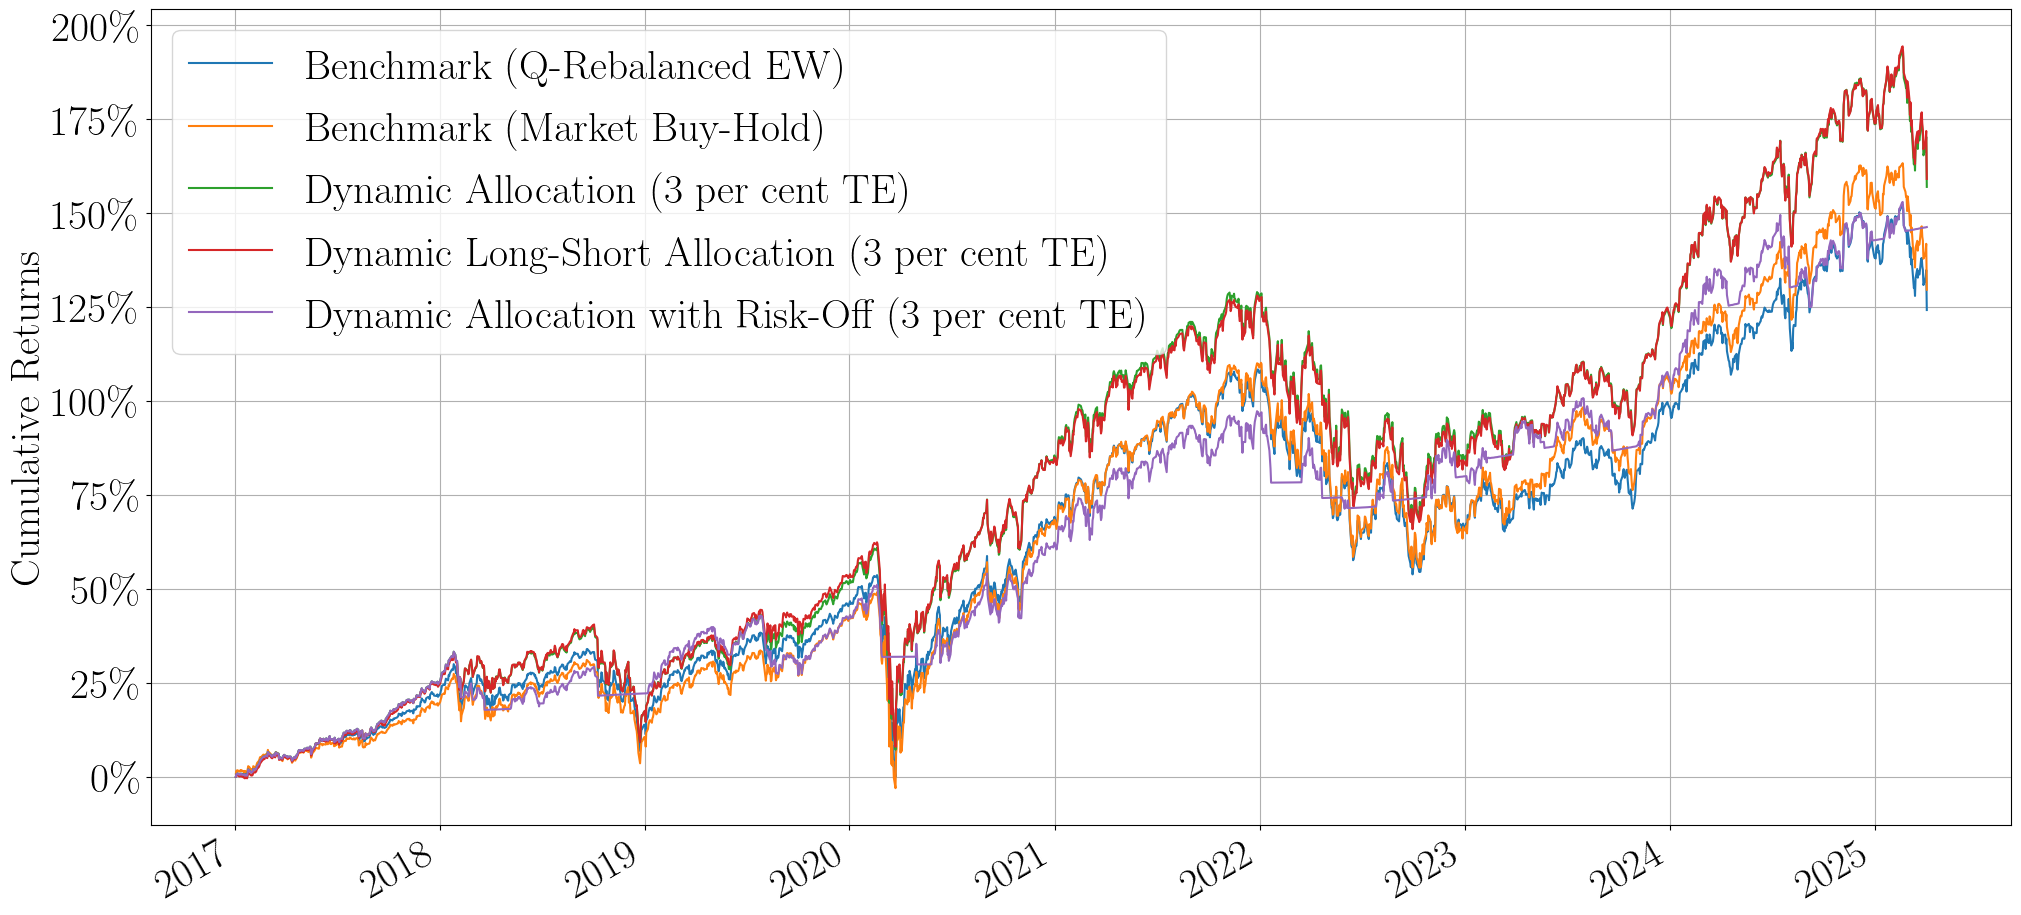

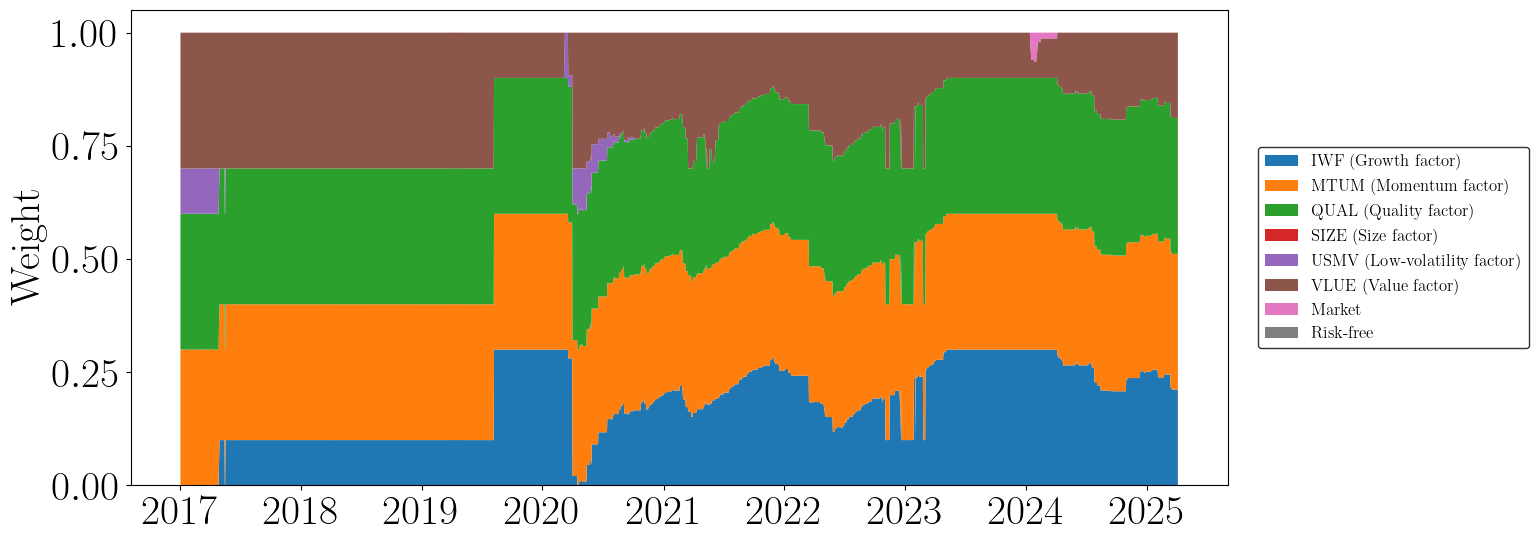

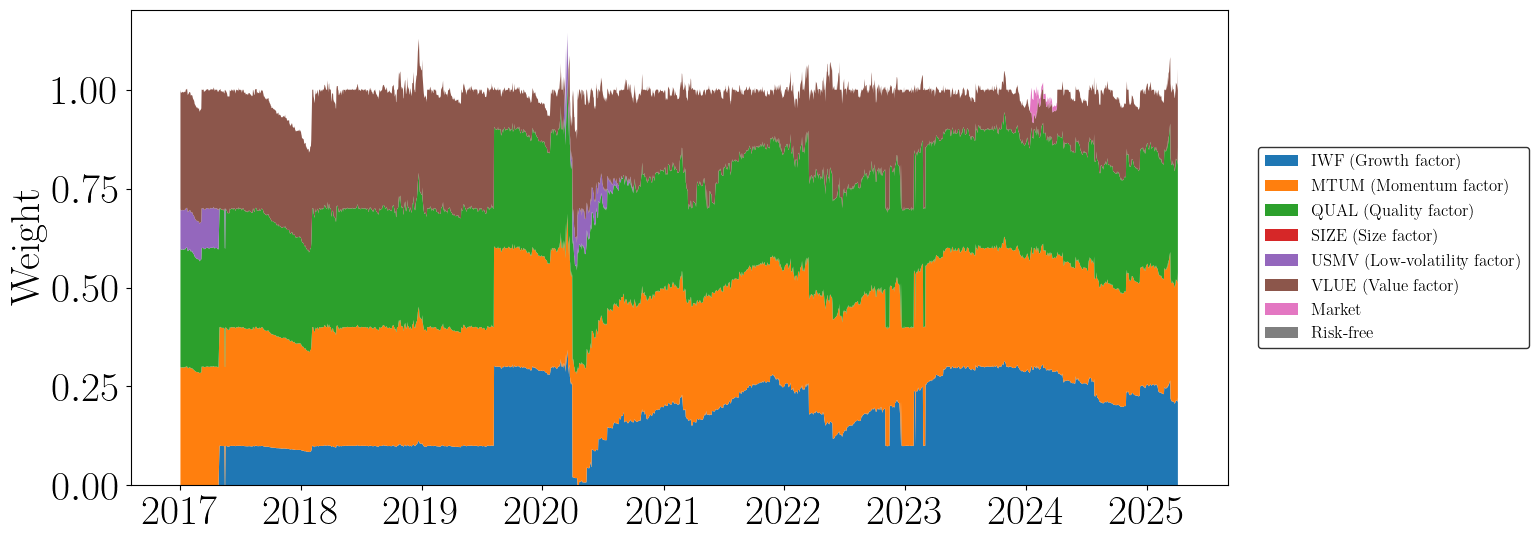

In [13]:

_update(
    compare=list(cmp.value),      # the configs you ticked in “Compare”
    weights_cfg=wgt.value,        # the config chosen in “Weights”
    sign_filter=sign.value        # 'both' / 'pos' / 'neg' from the toggle
)

In [29]:
# ------------------------------------------------------------
# QUICK CHECK — Is the L/S book really beta-neutral?
# ------------------------------------------------------------
#
# 1)  Pick the strategies you want to test.
#     (Long-only vs. corresponding long-short at the same TE.)
# 2)  Regress each portfolio’s *excess* daily returns on the
#     market’s *excess* daily returns → CAPM beta.
# 3)  Print both the full-sample beta and a 6-month rolling beta
#     so you can see whether neutrality is stable through time.
#
# Assumes `run_results` (your strategies) and `etf_df["Market"]`
# are already in memory, exactly as in your notebook.
# ------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def capm_beta(port_ret, mkt_ret):
    """OLS beta of portfolio excess return vs. market excess return."""
    y, x = port_ret.align(mkt_ret, join="inner")
    x = sm.add_constant(x)           # adds 'const' plus an unnamed column
    model = sm.OLS(y, x, missing="drop").fit()
    # beta is the coefficient after the intercept, whatever it's called
    return model.params.drop("const").iloc[0]



# -------- pick strategies ---------------------------------------
pairs = [
    ("Base model 3% TE",  "L/S 3% TE"),
    ("Base model 2% TE",  "L/S 2% TE"),
    ("Base model 1% TE",  "L/S 1% TE"),
]

mkt = etf_df["Market"].loc[full_idx] - etf_df["rf"].loc[full_idx]   # excess market return

results = []

for long_only, long_short in pairs:
    for lab in (long_only, long_short):
        r  = run_results[lab]["returns"]       # daily total return
        rex = r - etf_df["rf"].reindex(r.index)  # excess return
        beta = capm_beta(rex, mkt)
        results.append({"Strategy": lab, "CAPM beta": beta})

df_beta = pd.DataFrame(results).set_index("Strategy")
print(df_beta.round(3))

# -------- optional: rolling beta plot ---------------------------
window = 126     # ~6 months of trading days

for long_only, long_short in pairs:
    for lab, color in [(long_only, "tab:blue"), (long_short, "tab:orange")]:
        r  = run_results[lab]["returns"]
        rex = r - etf_df["rf"].reindex(r.index)
        roll_beta = (
            rex.rolling(window)
               .cov(mkt)
               / mkt.rolling(window).var()
        )
        roll_beta.plot(label=lab, color=color, alpha=0.8, lw=1.2)

    plt.axhline(0, color="grey", ls="--")
    plt.title(f"6-Month Rolling CAPM beta  ({long_only}  vs.  {long_short})")
    plt.ylabel("Beta to Market")
    plt.xlabel("")
    plt.legend()
    plt.grid(True)
    plt.ylim(0.6, 1.2)   # <-- set y-axis limits

    plt.show()



KeyError: 'Base model 3% TE'

In [35]:
# 5) Sharpe comparison tests vs EW
def sharpe_z_test(pnl, bench, periods=252):
    idx = pnl.index.intersection(bench.index)
    x, y = pnl.loc[idx], bench.loc[idx]
    n    = len(x)
    sr_p = x.mean()/x.std(ddof=1)
    sr_b = y.mean()/y.std(ddof=1)
    rho = np.corrcoef(x, y)[0, 1]
    var_p = (1 + 0.5*sr_p**2)/n
    var_b = (1 + 0.5*sr_b**2)/n
    var_diff = (1 + 0.5*sr_p**2)/n + (1 + 0.5*sr_b**2)/n - 2*rho*sr_p*sr_b/n
    z = (sr_p - sr_b) / np.sqrt(var_diff)
    p     = 2*(1 - stats.norm.cdf(abs(z)))
    return sr_p*np.sqrt(periods), sr_b*np.sqrt(periods), z, p

def sharpe_bootstrap_test(pnl, bench, periods=252, n_boot=10000, seed=0):
    idx = pnl.index.intersection(bench.index)
    x, y = pnl.loc[idx].to_numpy(), bench.loc[idx].to_numpy()
    n    = len(x)
    sr1  = x.mean()/x.std(ddof=1)*np.sqrt(periods)
    sr2  = y.mean()/y.std(ddof=1)*np.sqrt(periods)
    obs  = sr1 - sr2
    rng  = np.random.default_rng(seed)
    diffs = np.empty(n_boot)
    for i in range(n_boot):
        sel = rng.integers(0,n,size=n)
        x_b, y_b = x[sel], y[sel]
        sr1b = x_b.mean()/x_b.std(ddof=1)*np.sqrt(periods)
        sr2b = y_b.mean()/y_b.std(ddof=1)*np.sqrt(periods)
        diffs[i] = sr1b - sr2b
    p = 2*min((diffs >= obs).mean(), (diffs <= obs).mean())
    return obs, p

bench = ew_rets
# print("\nParametric Z-test vs EW:")
# for label, res in run_results.items():
#     sr_p, sr_b, z, p = sharpe_z_test(res["returns"], bench)
#     print(f"{label:25s} SR={sr_p:.3f} vs EW={sr_b:.3f}, z={z:+.2f}, p={p:.3f}")

print("\nBootstrap test vs EW:")
for label, res in run_results.items():
    diff, p = sharpe_bootstrap_test(res["returns"], bench)
    print(f"{label:25s} ΔSR={diff:+.3f}, p={p:.3f}")



Bootstrap test vs EW:
Base model 4% TE          ΔSR=+0.077, p=0.970
Base model 3% TE          ΔSR=+0.071, p=0.961
Base model 2% TE          ΔSR=+0.066, p=0.984
Base model 1% TE          ΔSR=+0.075, p=0.993
L/S 4% TE                 ΔSR=+0.063, p=0.957
L/S 3% TE                 ΔSR=+0.073, p=0.963
L/S 2% TE                 ΔSR=+0.085, p=0.978
L/S 1% TE                 ΔSR=+0.093, p=0.996
Risk-off 4% TE            ΔSR=+0.325, p=0.987
Risk-off 3% TE            ΔSR=+0.340, p=0.992
Risk-off 2% TE            ΔSR=+0.359, p=0.986
Risk-off 1% TE            ΔSR=+0.405, p=0.989
Benchmark (Market Buy-Hold) ΔSR=+0.003, p=1.000
Benchmark (Q-Rebalanced EW) ΔSR=+0.000, p=2.000


In [36]:
# %%
# 6) Jobson-Korkie with Memmel correction + Ledoit-Wolf tests
import numpy as np
from math import sqrt
from scipy.stats import norm

def jobson_korkie_memmel_test(strat, bench, periods=252):
    """
    Tests the difference in Sharpe ratios using the
    Jobson-Korkie test with Memmel (2003) correction.
    Returns (SR_strat, SR_bench, z_stat, p_value).
    """
    # Ensure alignment:
    idx = strat.index.intersection(bench.index)
    x   = strat.loc[idx].values
    y   = bench.loc[idx].values
    n   = len(x)

    # Annualized means and std dev
    mean_x, mean_y = x.mean(), y.mean()
    std_x, std_y = x.std(ddof=1), y.std(ddof=1)
    sr_x           = mean_x / std_x
    sr_y           = mean_y / std_y

    # Correlation
    rho = np.corrcoef(x, y)[0,1]

    # --- Memmel’s correction formula (z-stat denominator) ---
    # Basic JK formula: var(ΔSR) = (1/n)*(2*(1-rho) + 0.5*sr_x^2 + 0.5*sr_y^2 - rho*sr_x*sr_y)
    # Memmel adjusts the factor from (2*(1-rho)) to (2 - 2*rho), same structure. 
    # Implementation differences vary by reference, but the typical approach is:
    var_diff  = (1.0/n) * ( 2.0 - 2.0*rho 
                            + 0.5*sr_x**2 + 0.5*sr_y**2 
                            - rho*sr_x*sr_y )
    sr_diff   = sr_x - sr_y
    denom     = sqrt(var_diff)
    z_value   = sr_diff / denom if denom>1e-12 else 0.0
    p_value   = 2.0 * (1.0 - norm.cdf(abs(z_value)))

    return sr_x*np.sqrt(periods), sr_y*np.sqrt(periods), z_value, p_value

def ledoit_wolf_sharpe_test(strat, bench, periods=252):
    """
    Tests the difference in Sharpe ratios using the
    Ledoit-Wolf (2008) asymptotic distribution approach.
    Returns (SR_strat, SR_bench, z_stat, p_value).
    """
    # Align
    idx = strat.index.intersection(bench.index)
    x   = strat.loc[idx].values
    y   = bench.loc[idx].values
    n   = len(x)

    # Annualized means and std dev
    mean_x, mean_y = x.mean(), y.mean()
    std_x, std_y = x.std(ddof=1), y.std(ddof=1)
    sr_x           = mean_x / std_x
    sr_y           = mean_y / std_y
    sr_diff        = sr_x - sr_y

    # As in Ledoit-Wolf (2008), the standard error depends on higher moments, 
    # but here's a simplified typical implementation:
    corr  = np.corrcoef(x, y)[0,1]
    # approximate the difference's variance:
    var_x = (1.0 + 0.5 * sr_x**2) / n
    var_y = (1.0 + 0.5 * sr_y**2) / n
    cov_xy = (corr * sr_x * sr_y) / n
    var_diff = var_x + var_y - 2.0 * cov_xy

    denom = np.sqrt(var_diff)
    z_val = sr_diff / denom if denom > 1e-12 else 0.0
    p_val = 2.0 * (1.0 - norm.cdf(abs(z_val)))

    return sr_x*np.sqrt(periods), sr_y*np.sqrt(periods), z_val, p_val

# Compare each strategy's Sharpe to EW using JK (Memmel) & Ledoit-Wolf
print("\nJobson-Korkie (Memmel) test vs EW:")
for label, res in run_results.items():
    sr_s, sr_b, z, p = jobson_korkie_memmel_test(res["returns"], ew_rets)
    print(f"{label:25s} ΔSR={sr_s - sr_b:+.3f}, z={z:+.2f}, p={p:.3f}")

print("\nLedoit-Wolf test vs EW:")
for label, res in run_results.items():
    sr_s, sr_b, z, p = ledoit_wolf_sharpe_test(res["returns"], ew_rets)
    print(f"{label:25s} ΔSR={sr_s - sr_b:+.3f}, z={z:+.2f}, p={p:.3f}")



Jobson-Korkie (Memmel) test vs EW:
Base model 4% TE          ΔSR=+0.077, z=+1.60, p=0.110
Base model 3% TE          ΔSR=+0.071, z=+1.75, p=0.081
Base model 2% TE          ΔSR=+0.066, z=+1.73, p=0.083
Base model 1% TE          ΔSR=+0.075, z=+1.96, p=0.050
L/S 4% TE                 ΔSR=+0.063, z=+1.23, p=0.218
L/S 3% TE                 ΔSR=+0.073, z=+1.59, p=0.111
L/S 2% TE                 ΔSR=+0.085, z=+2.01, p=0.044
L/S 1% TE                 ΔSR=+0.093, z=+2.32, p=0.020
Risk-off 4% TE            ΔSR=+0.325, z=+1.07, p=0.283
Risk-off 3% TE            ΔSR=+0.340, z=+1.13, p=0.260
Risk-off 2% TE            ΔSR=+0.359, z=+1.19, p=0.232
Risk-off 1% TE            ΔSR=+0.405, z=+1.35, p=0.178
Benchmark (Market Buy-Hold) ΔSR=+0.003, z=+0.10, p=0.923
Benchmark (Q-Rebalanced EW) ΔSR=+0.000, z=+0.00, p=1.000

Ledoit-Wolf test vs EW:
Base model 4% TE          ΔSR=+0.077, z=+0.16, p=0.875
Base model 3% TE          ΔSR=+0.071, z=+0.14, p=0.885
Base model 2% TE          ΔSR=+0.066, z=+0.13, p=0.893


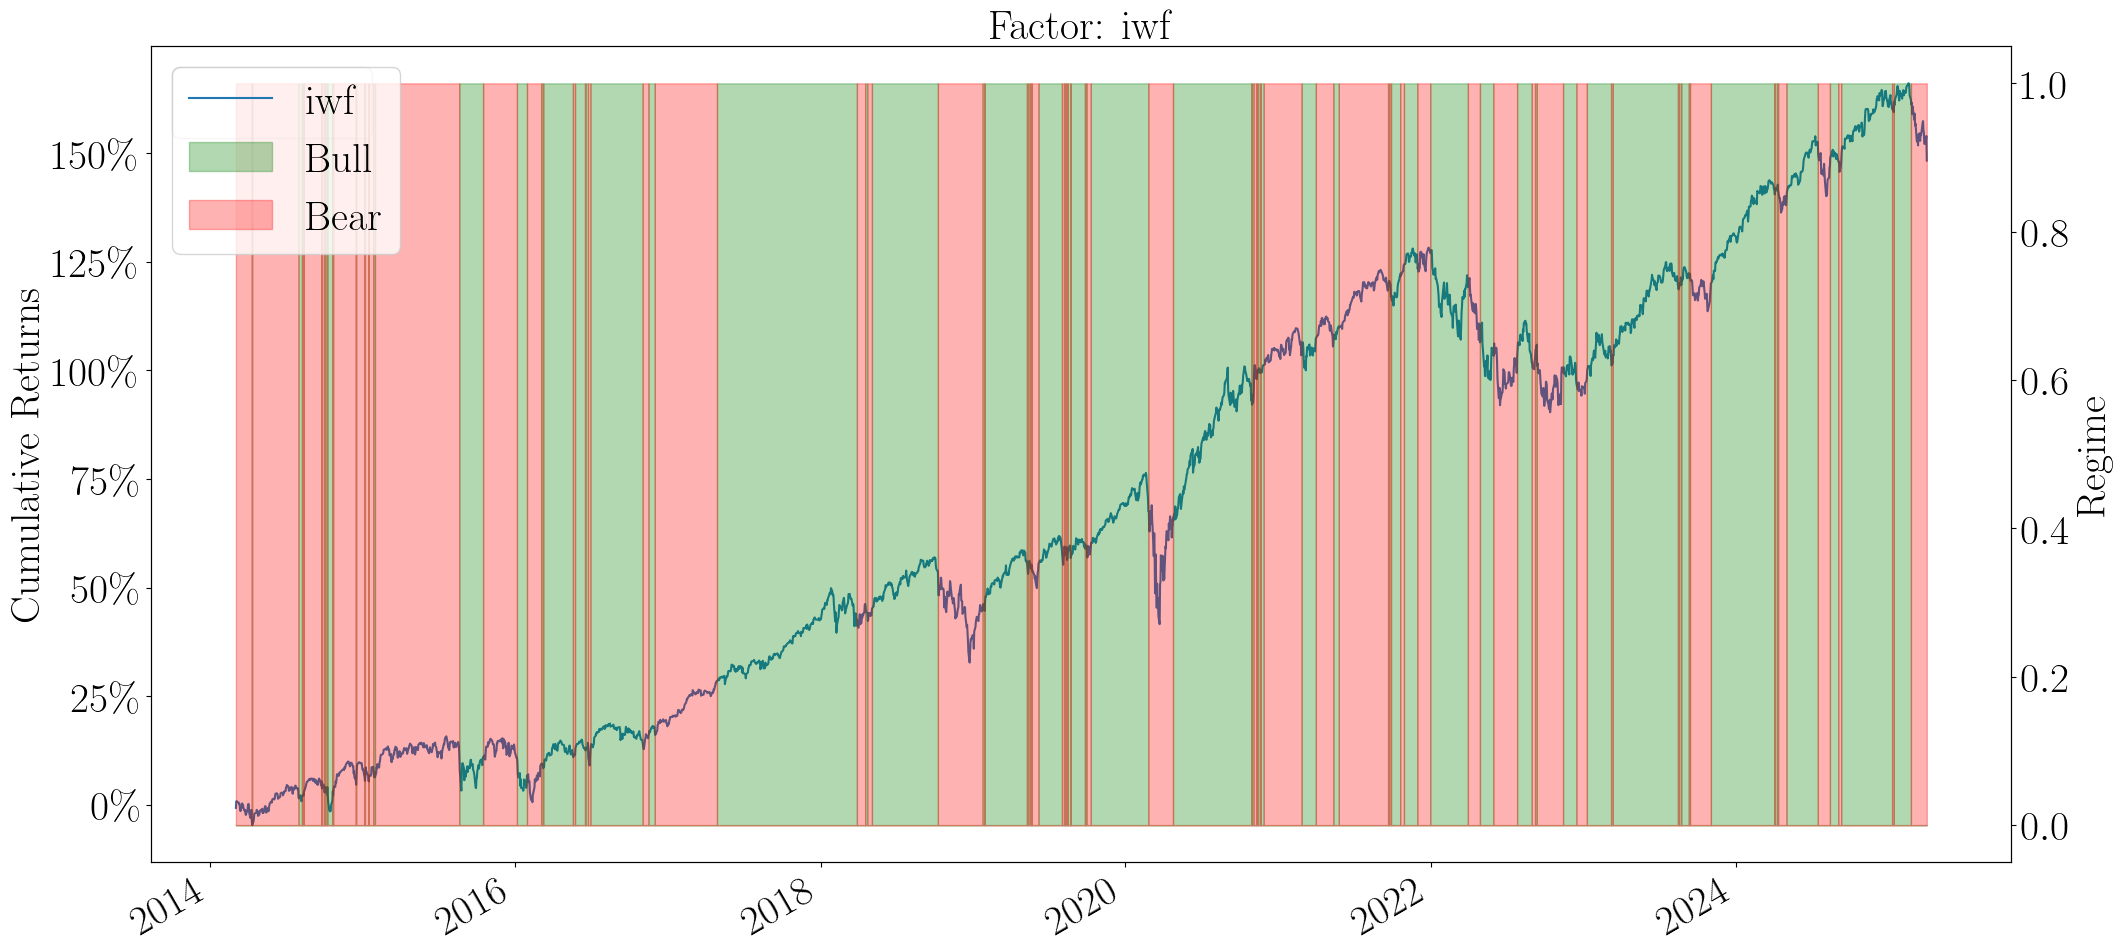

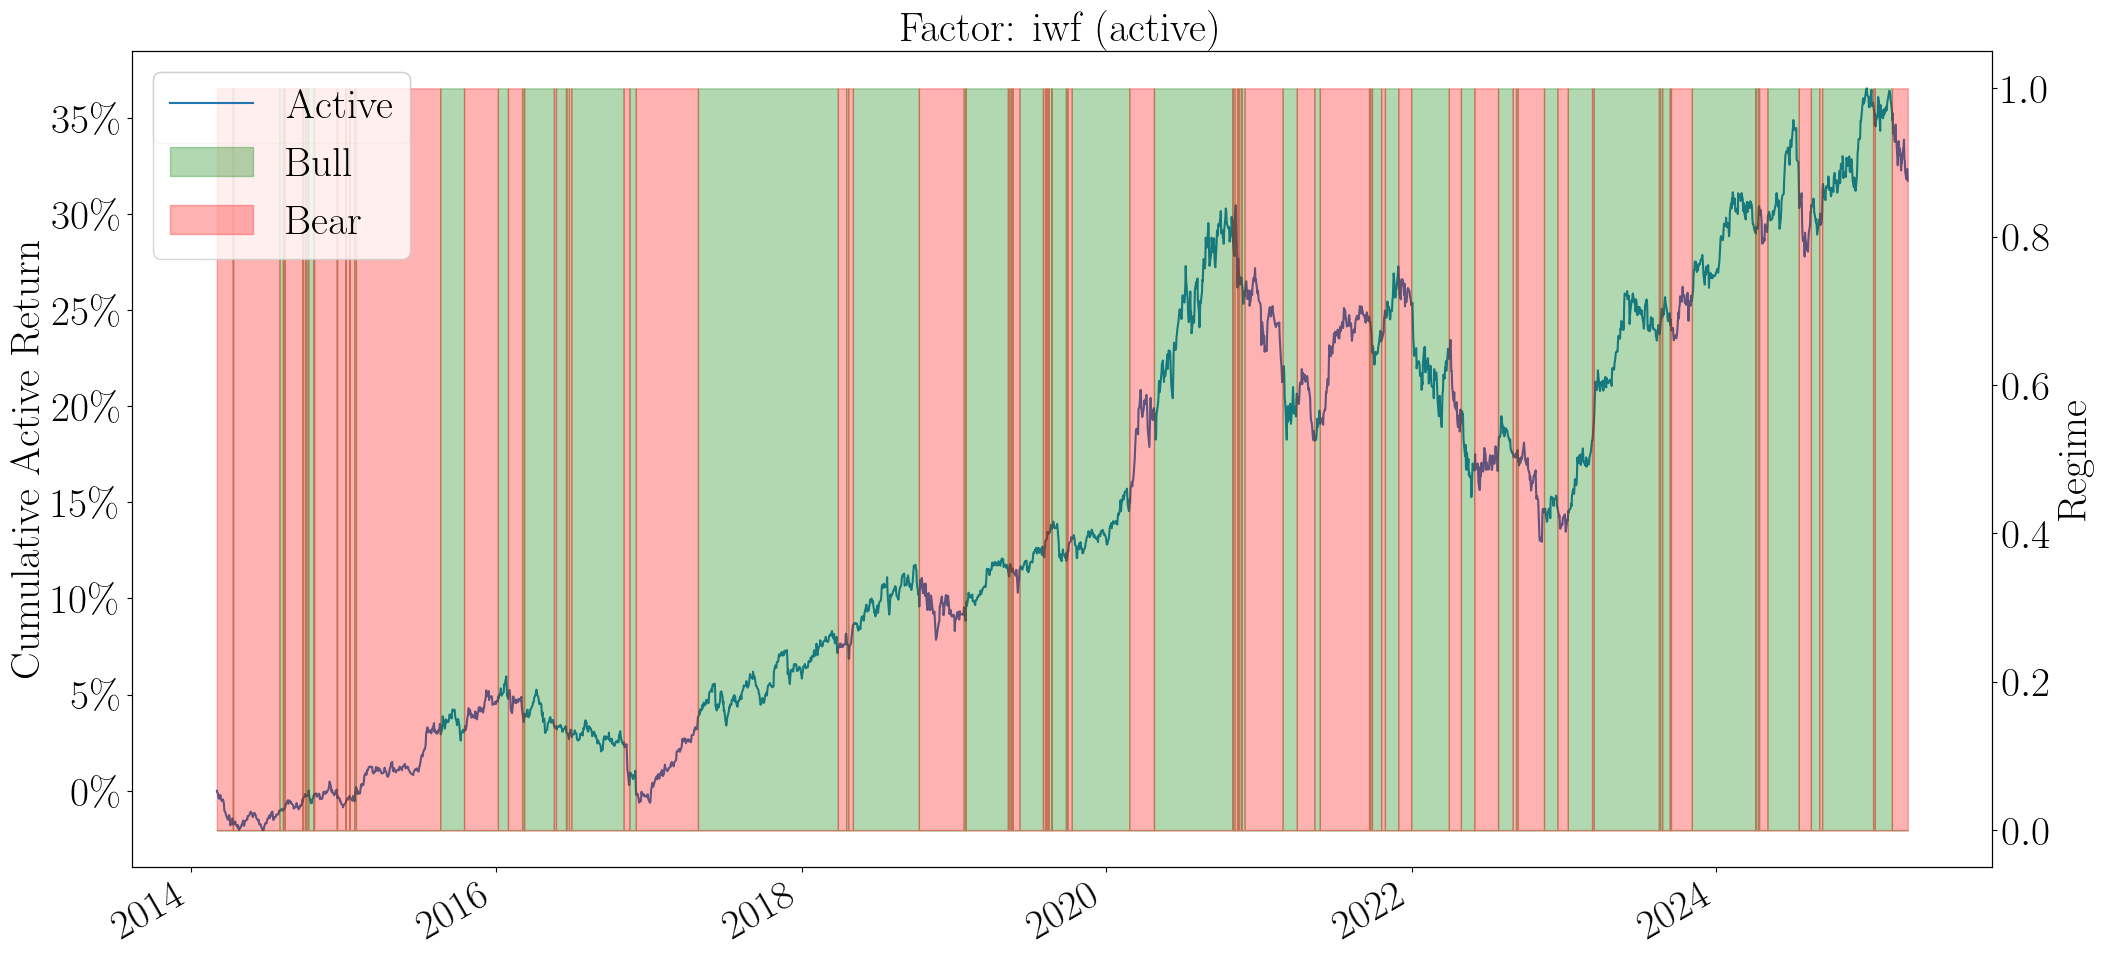

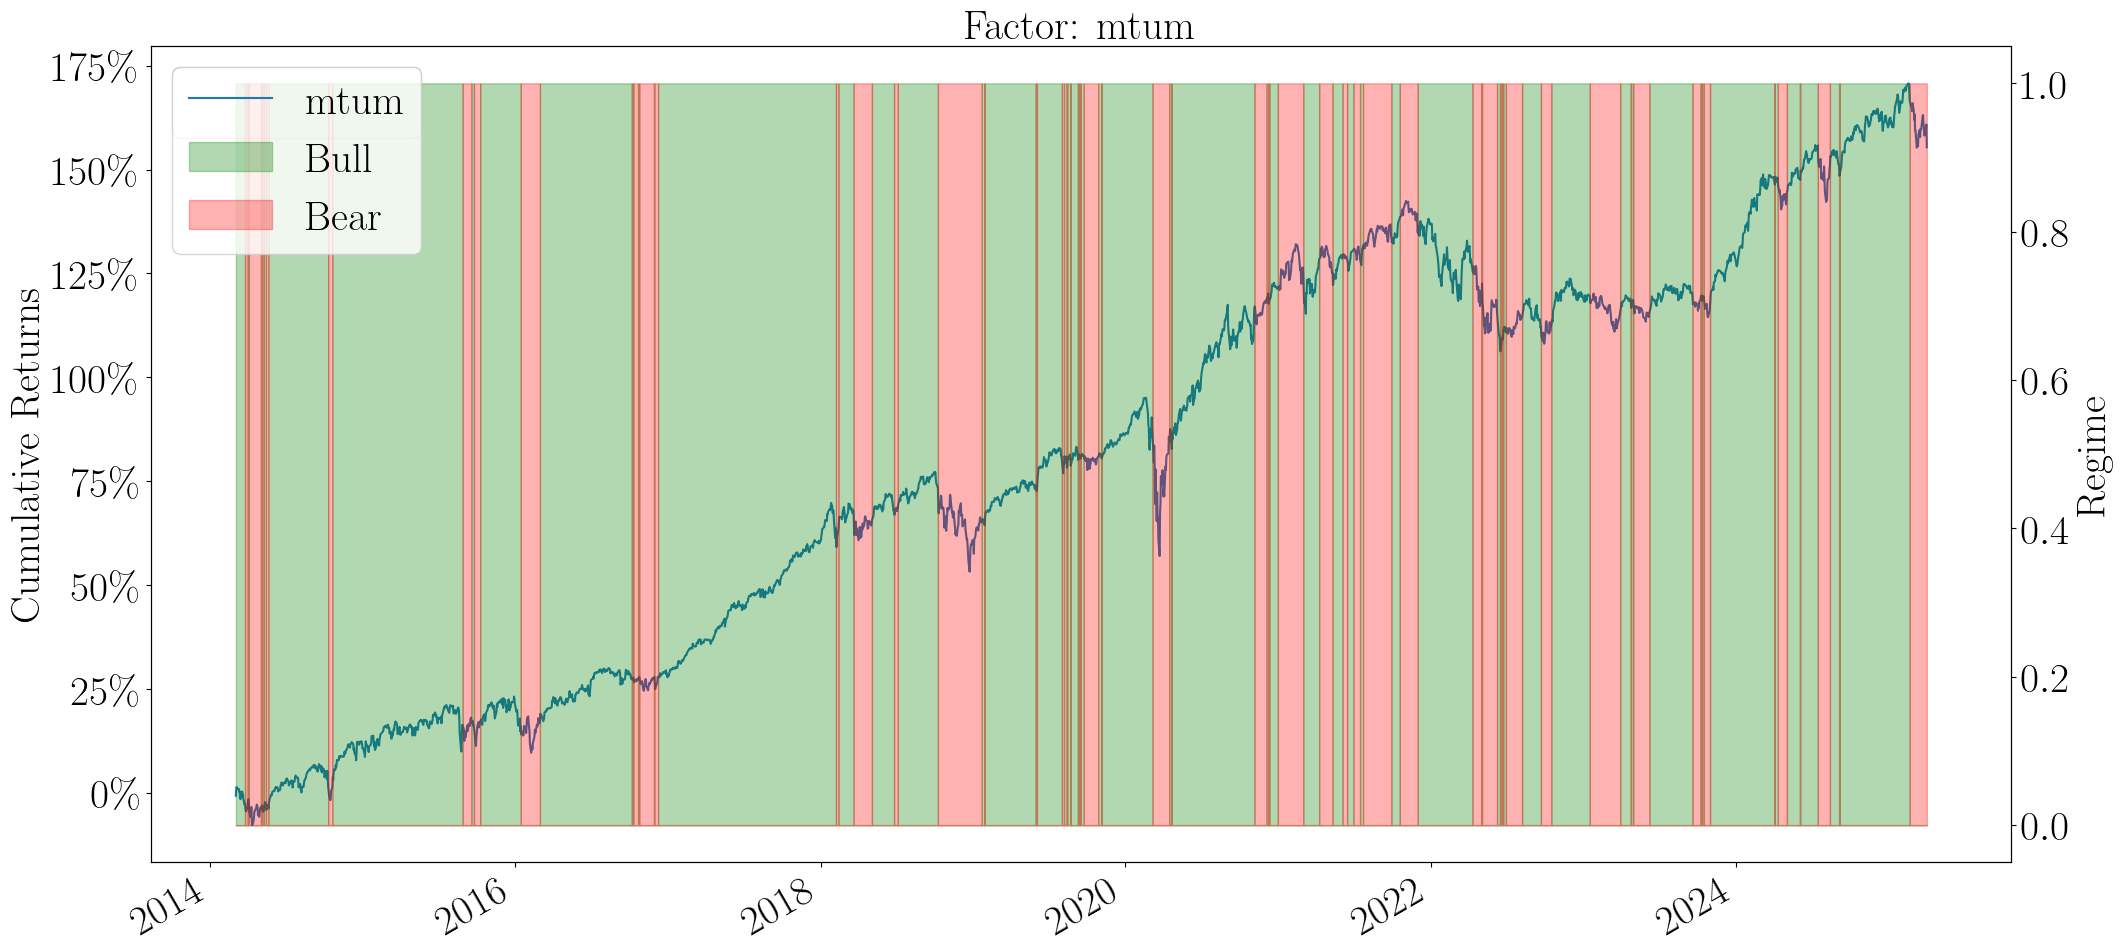

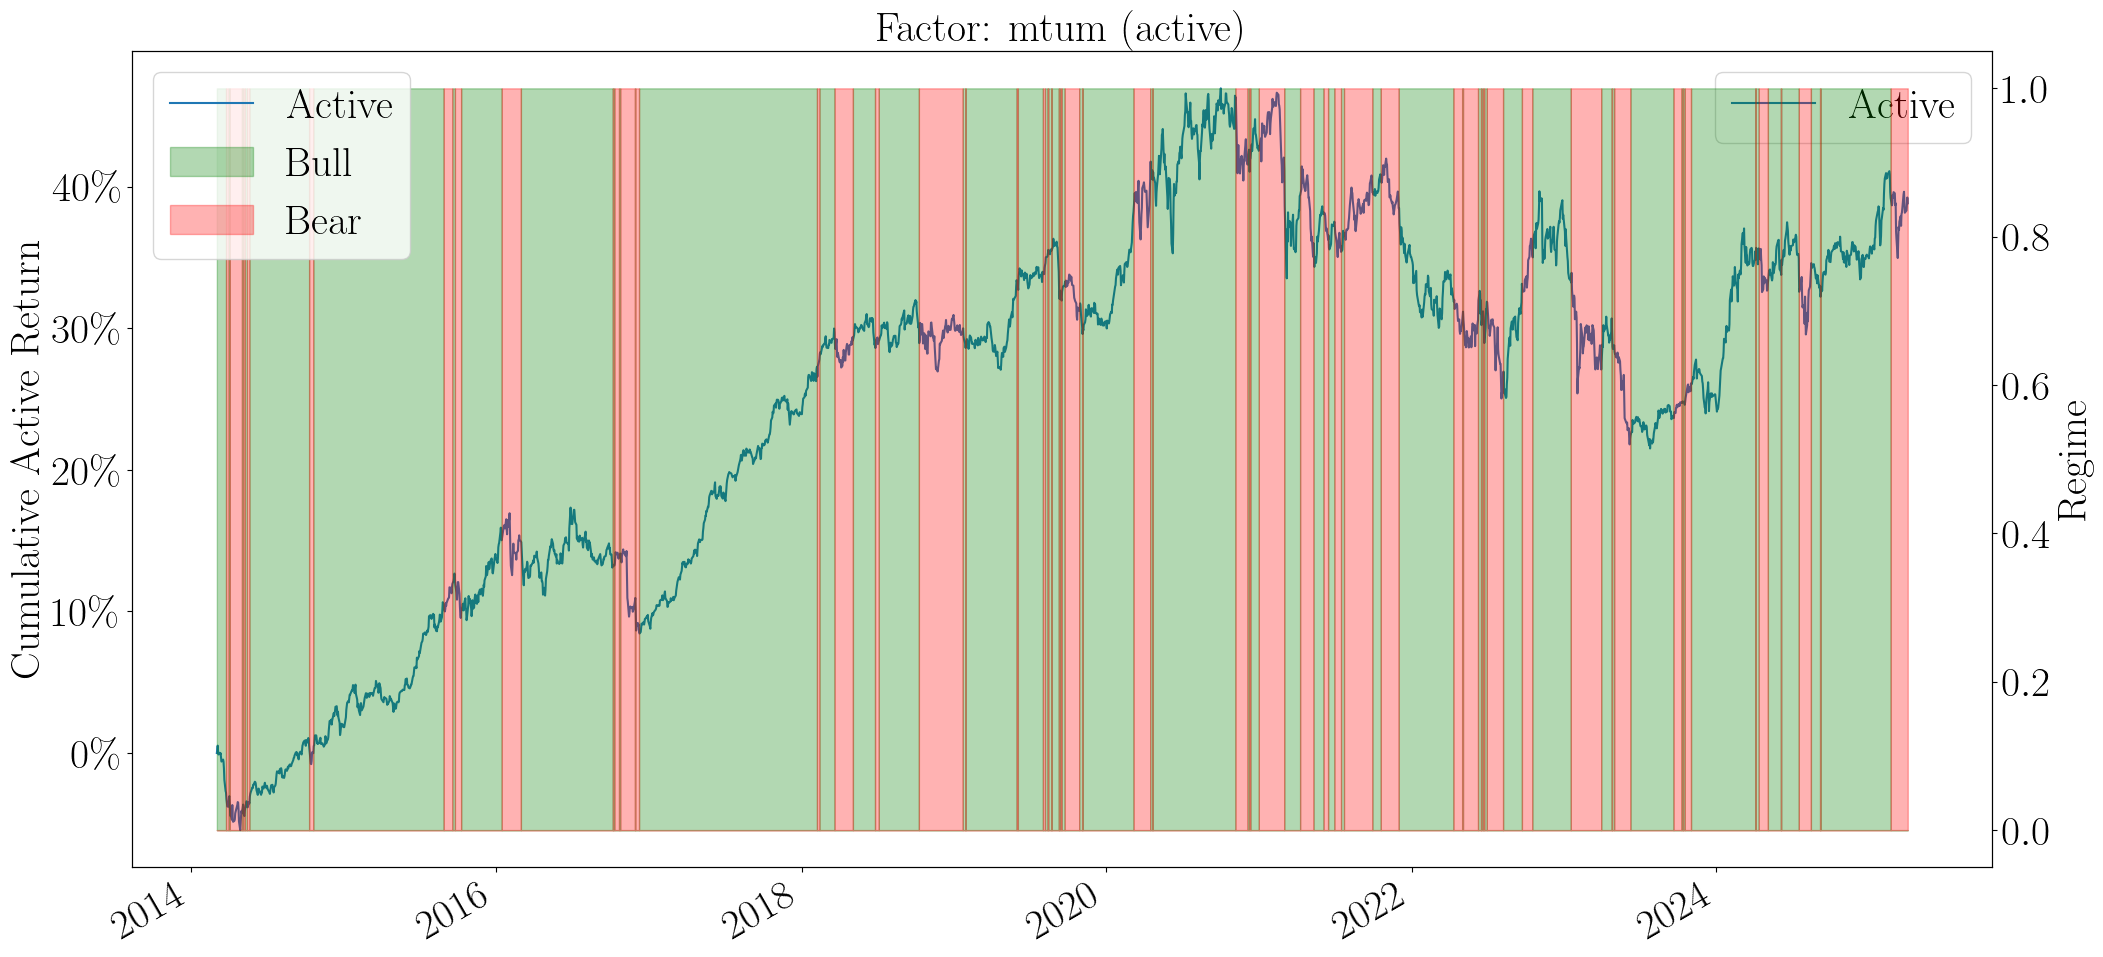

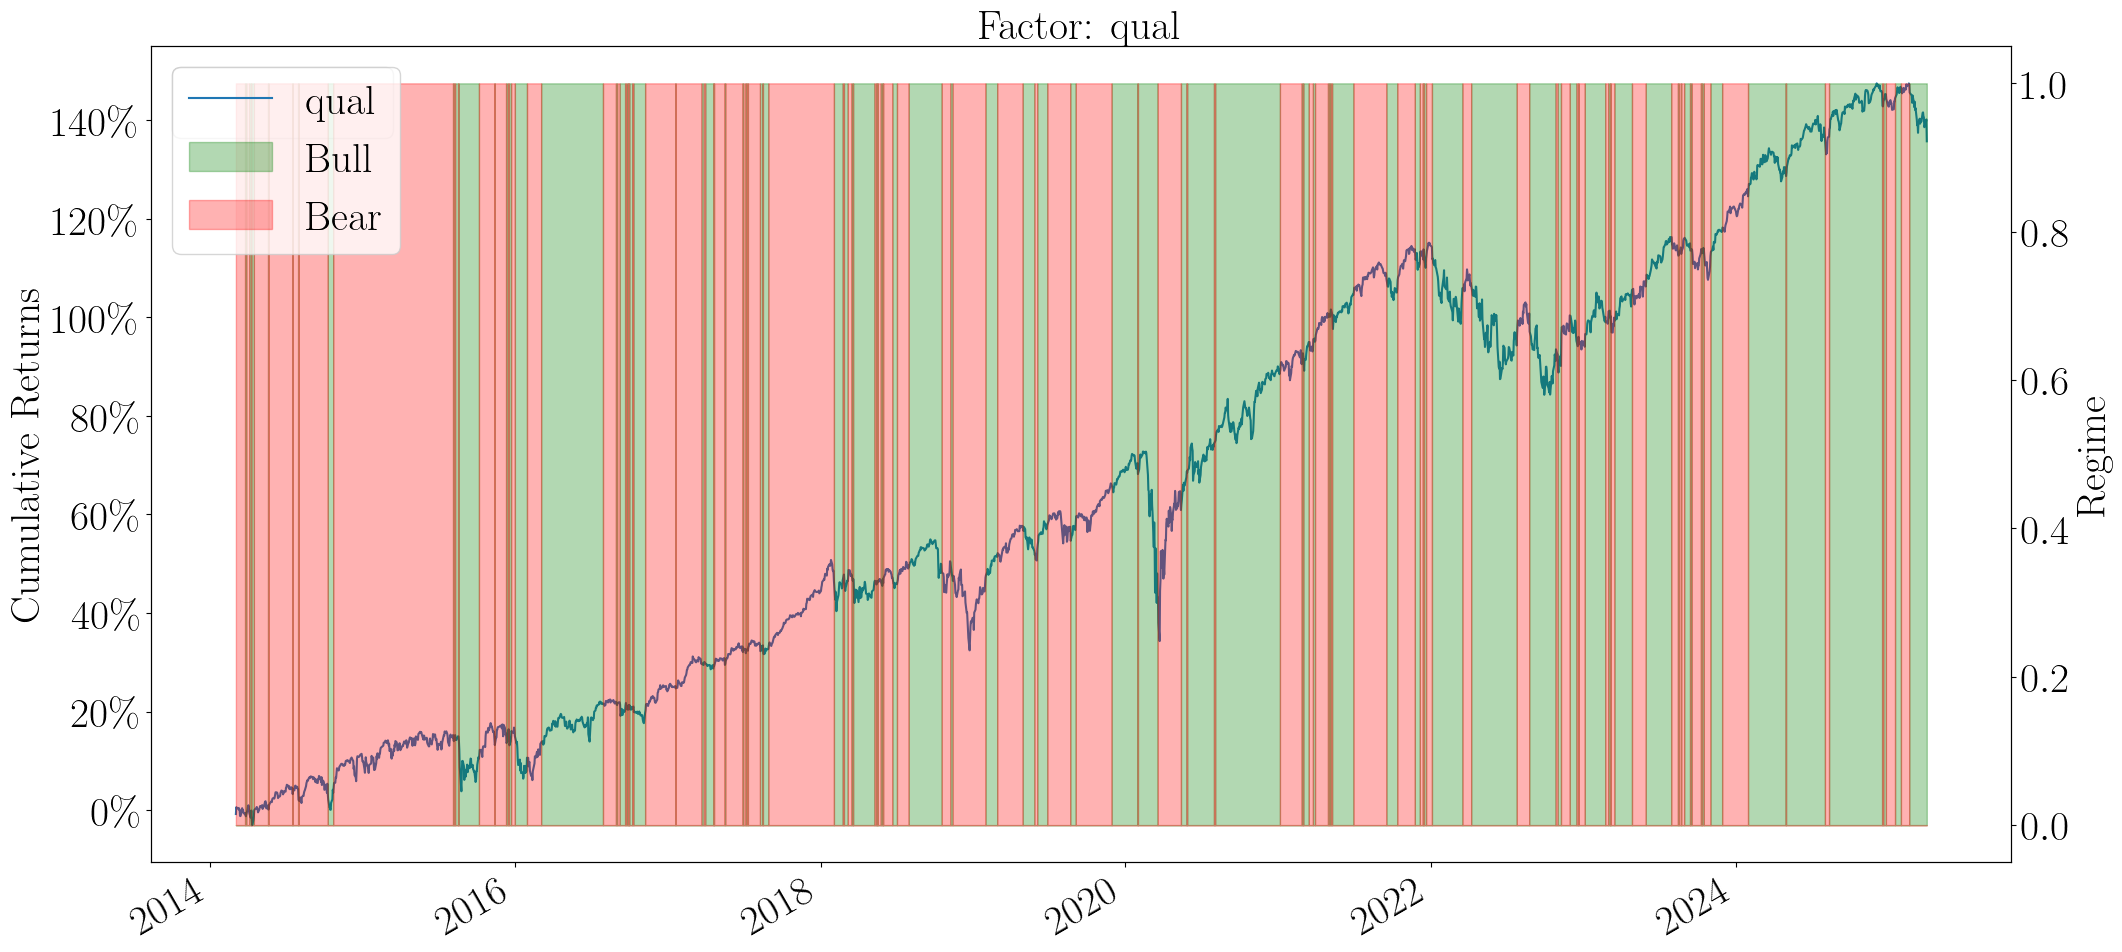

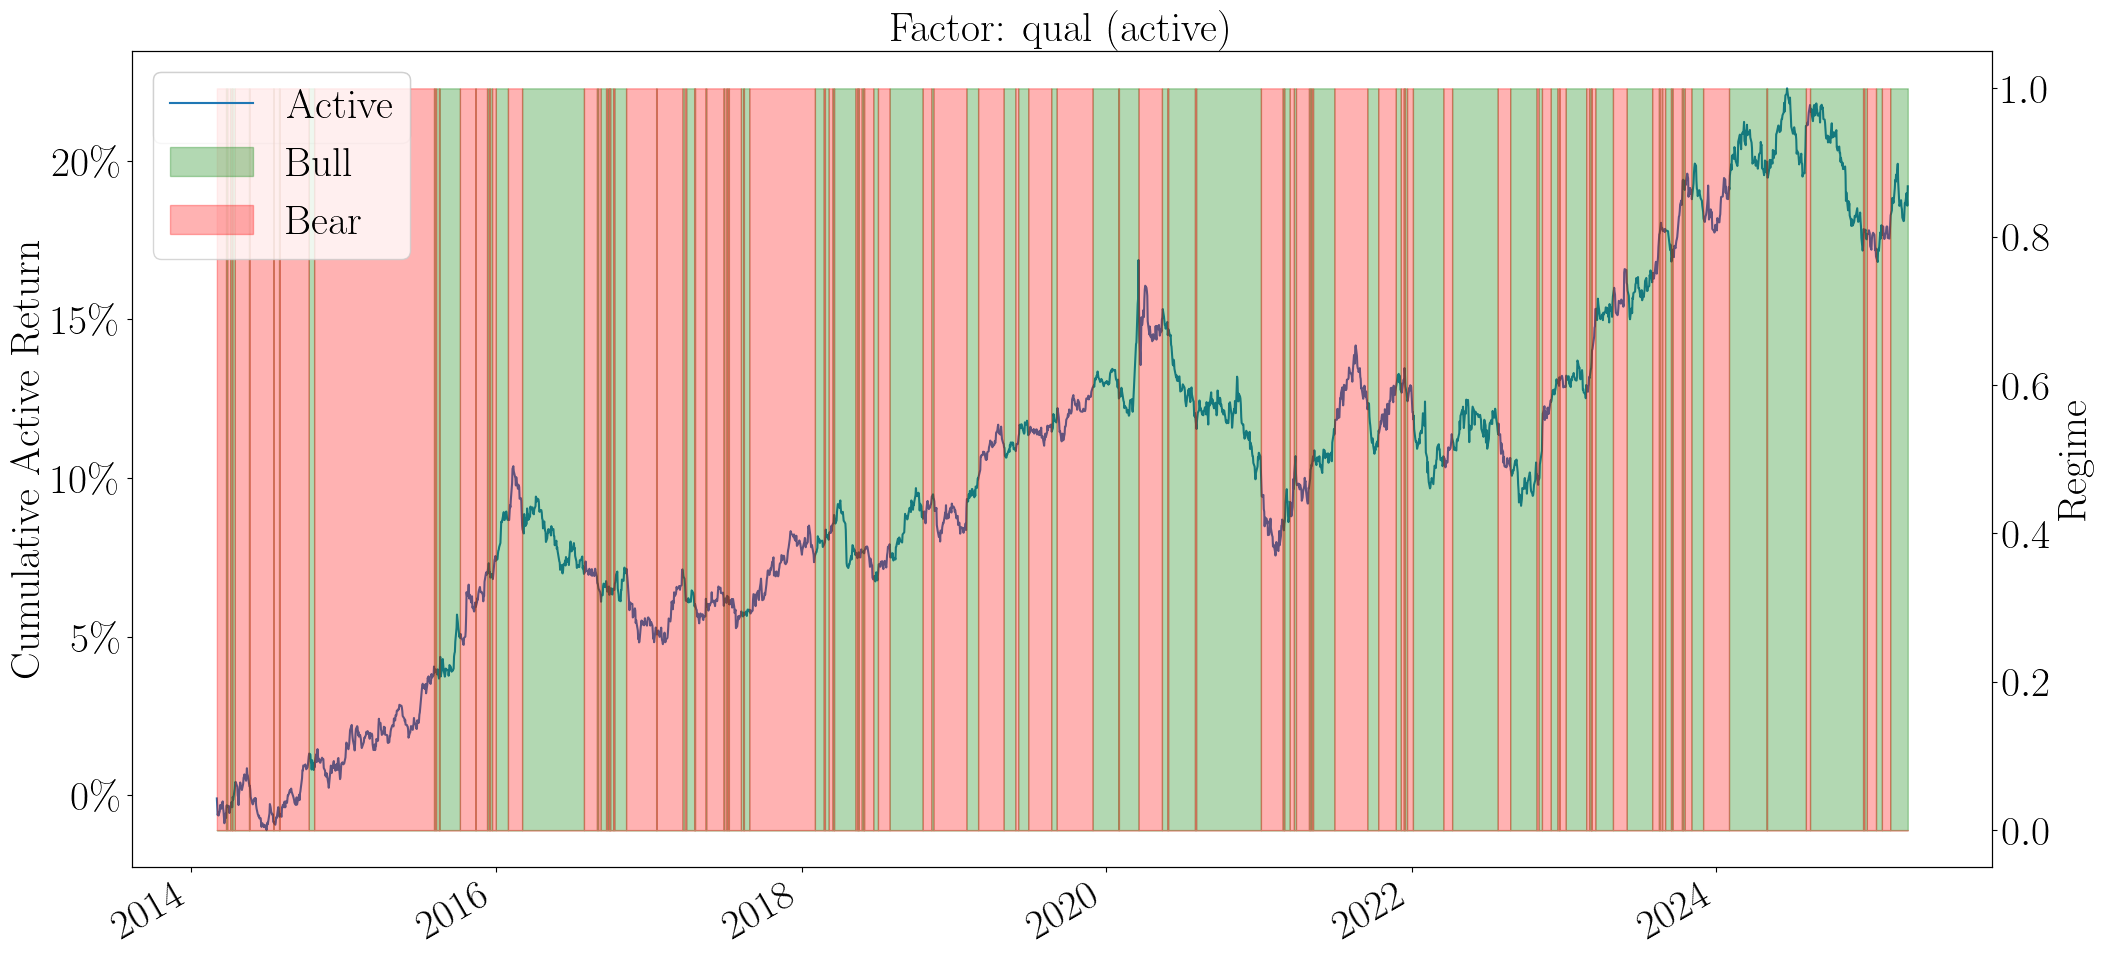

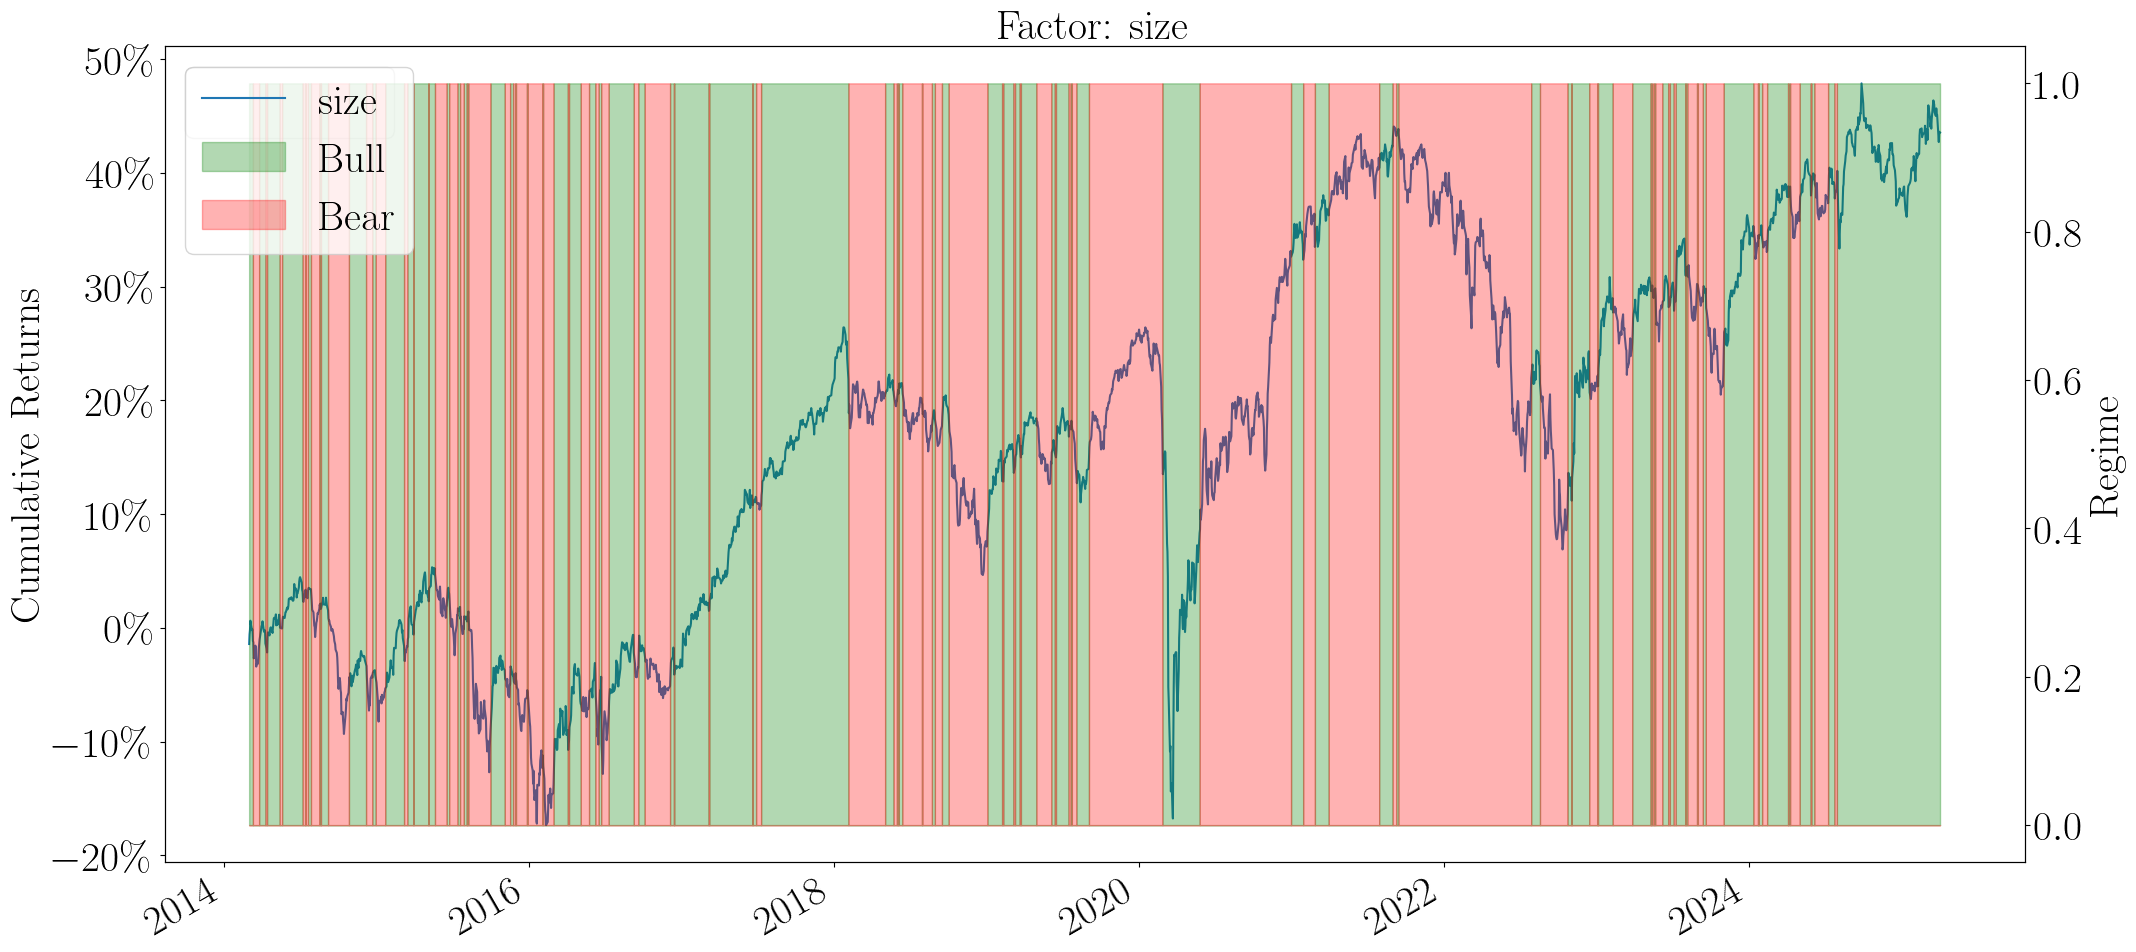

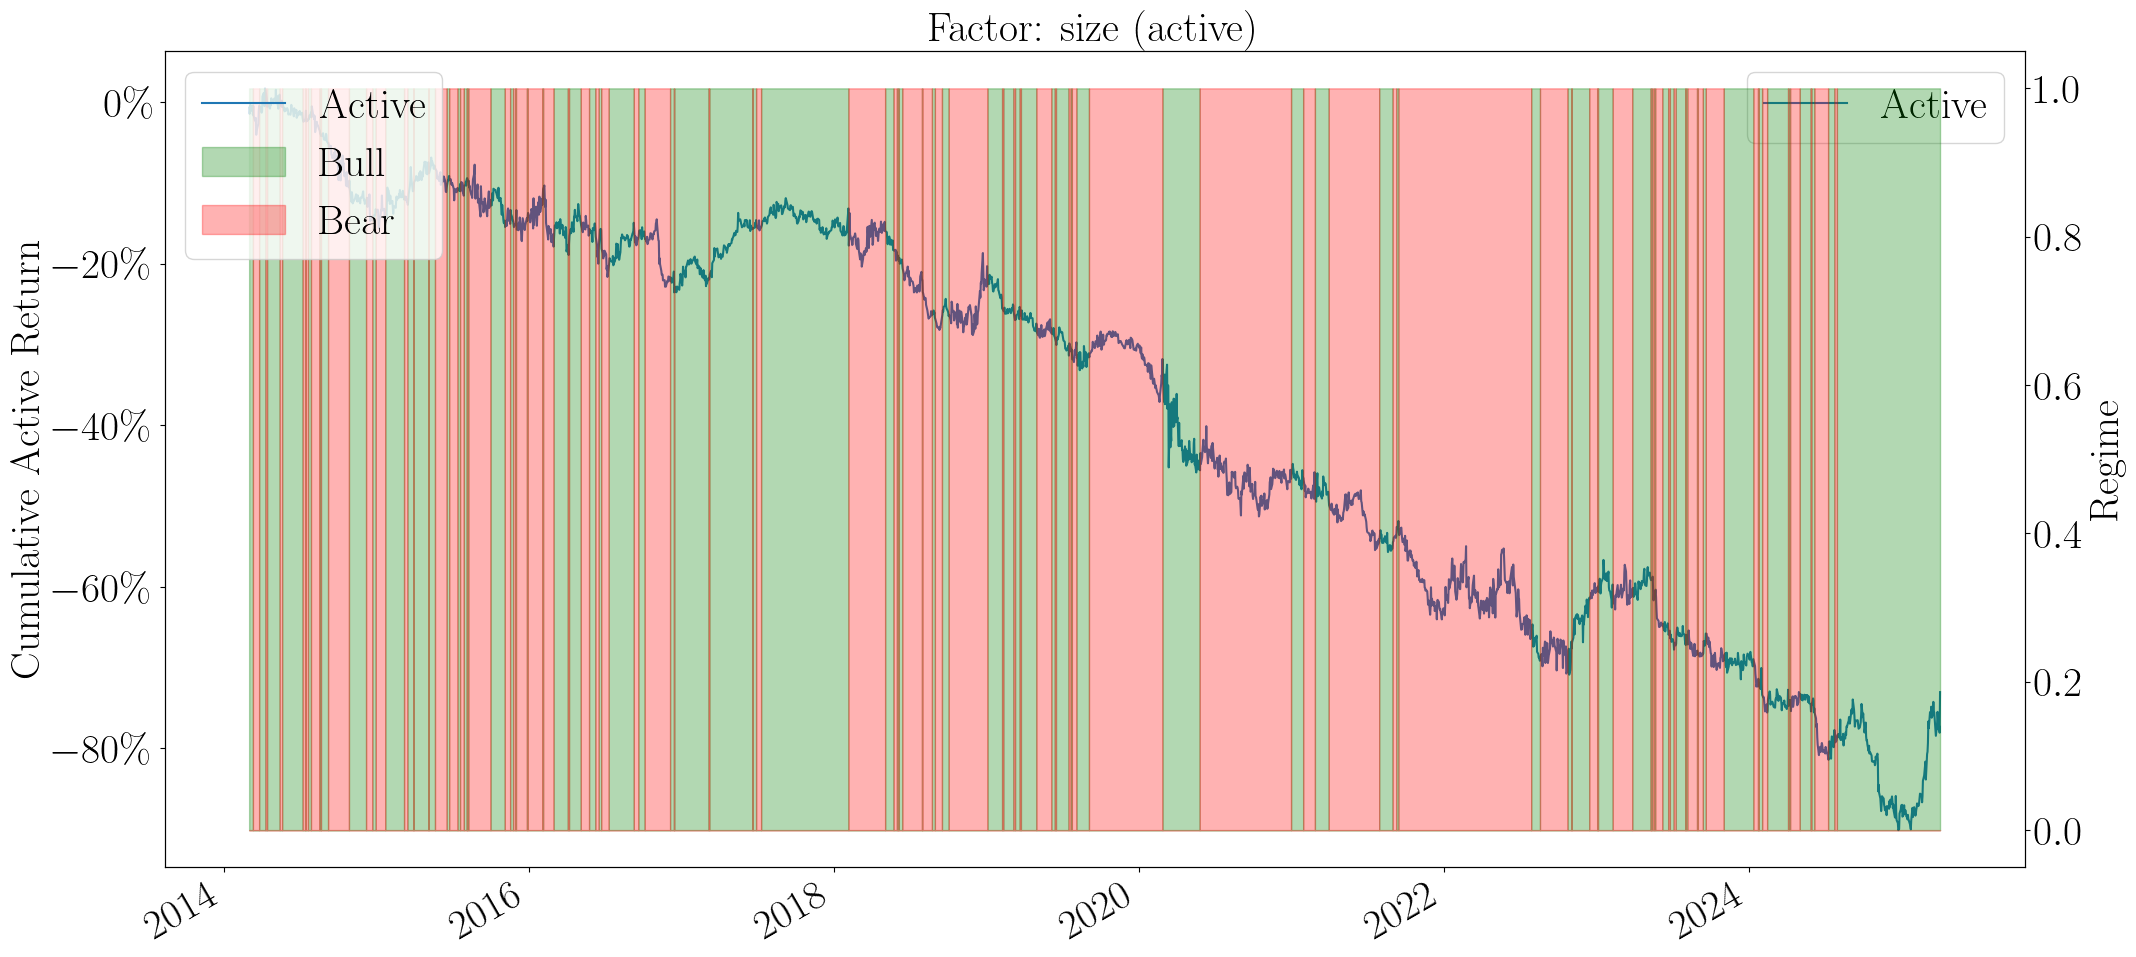

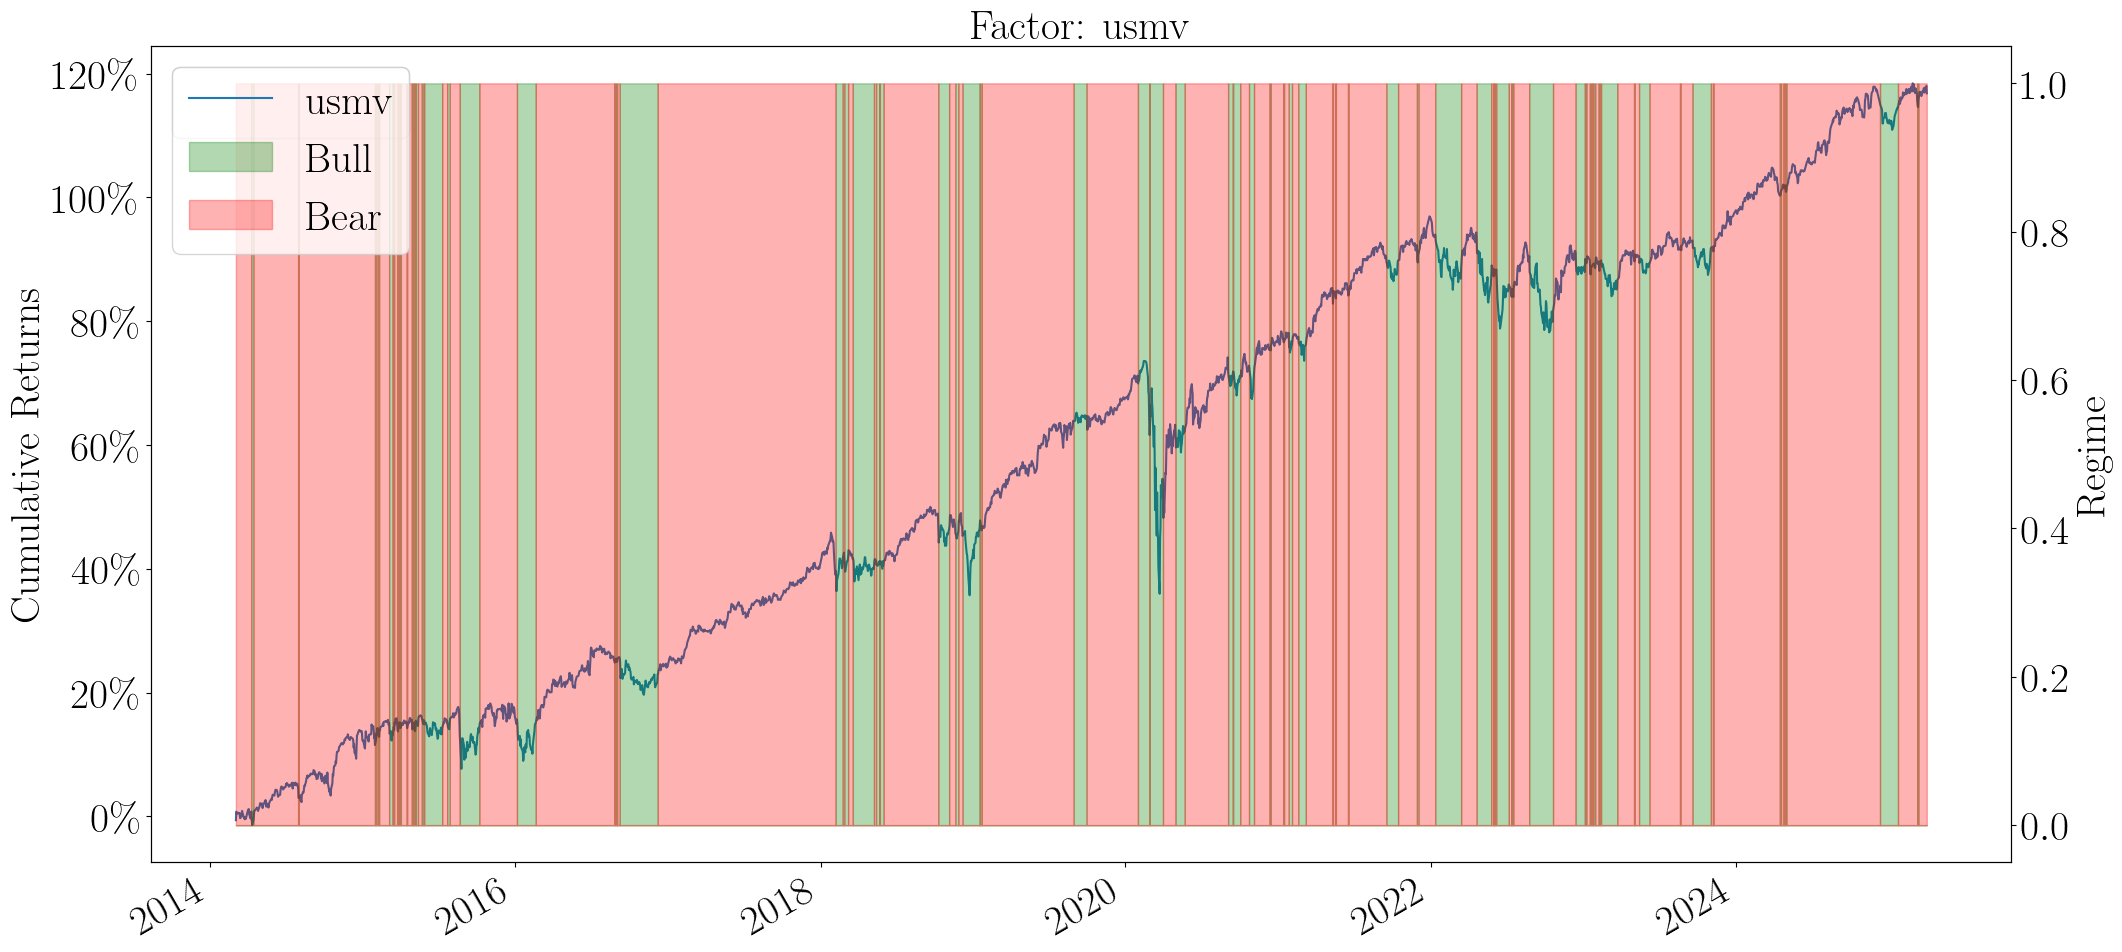

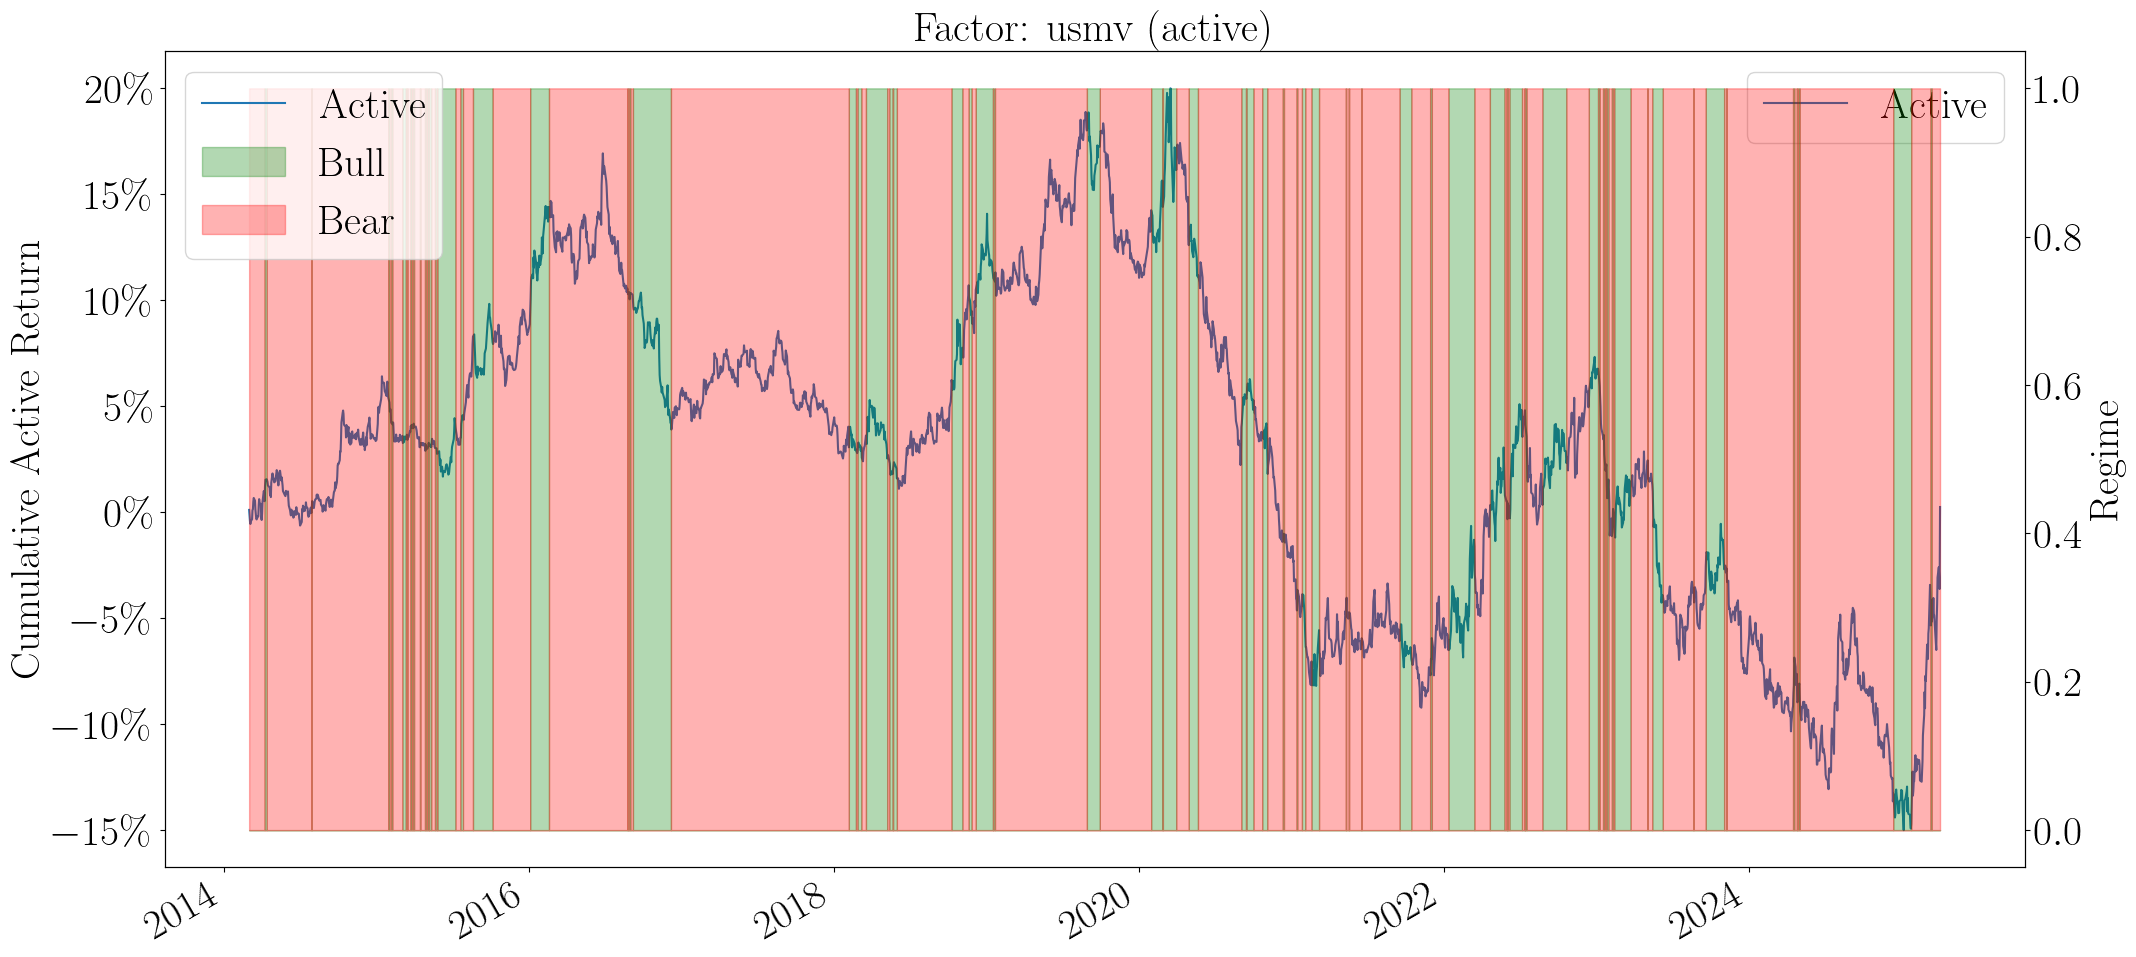

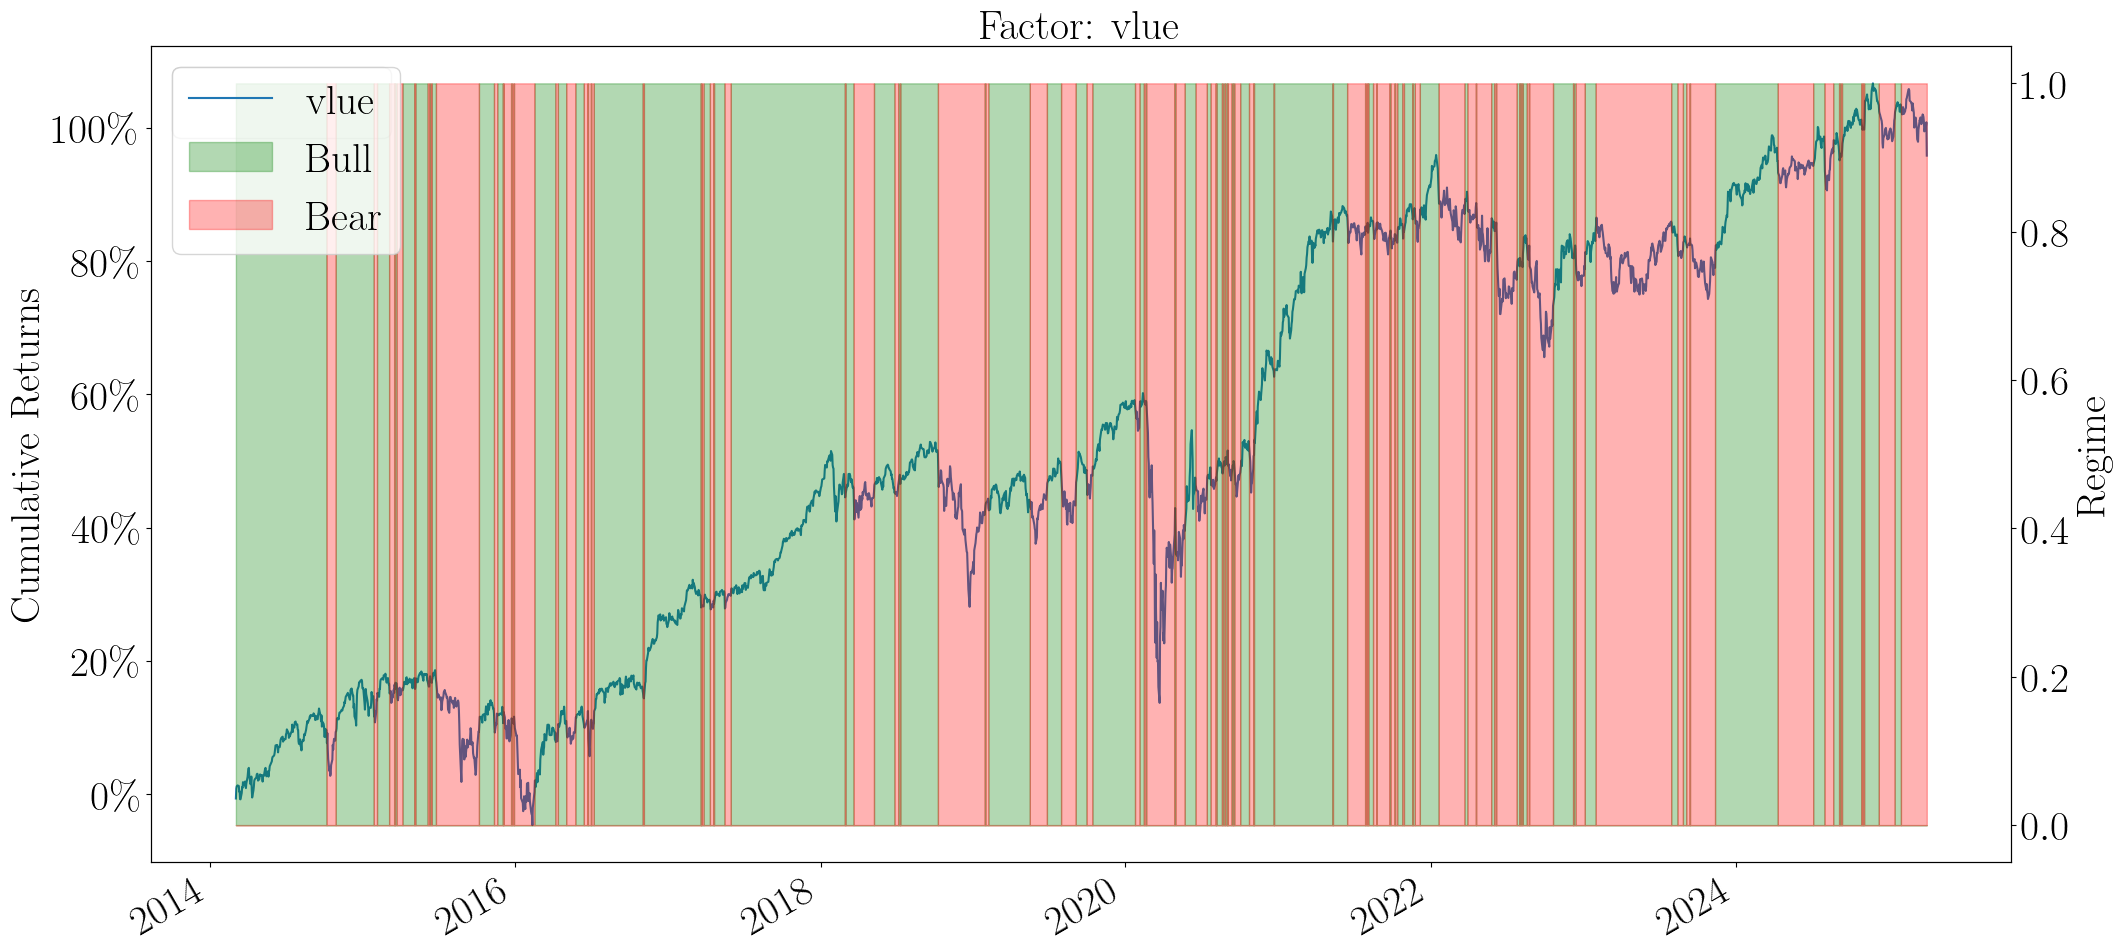

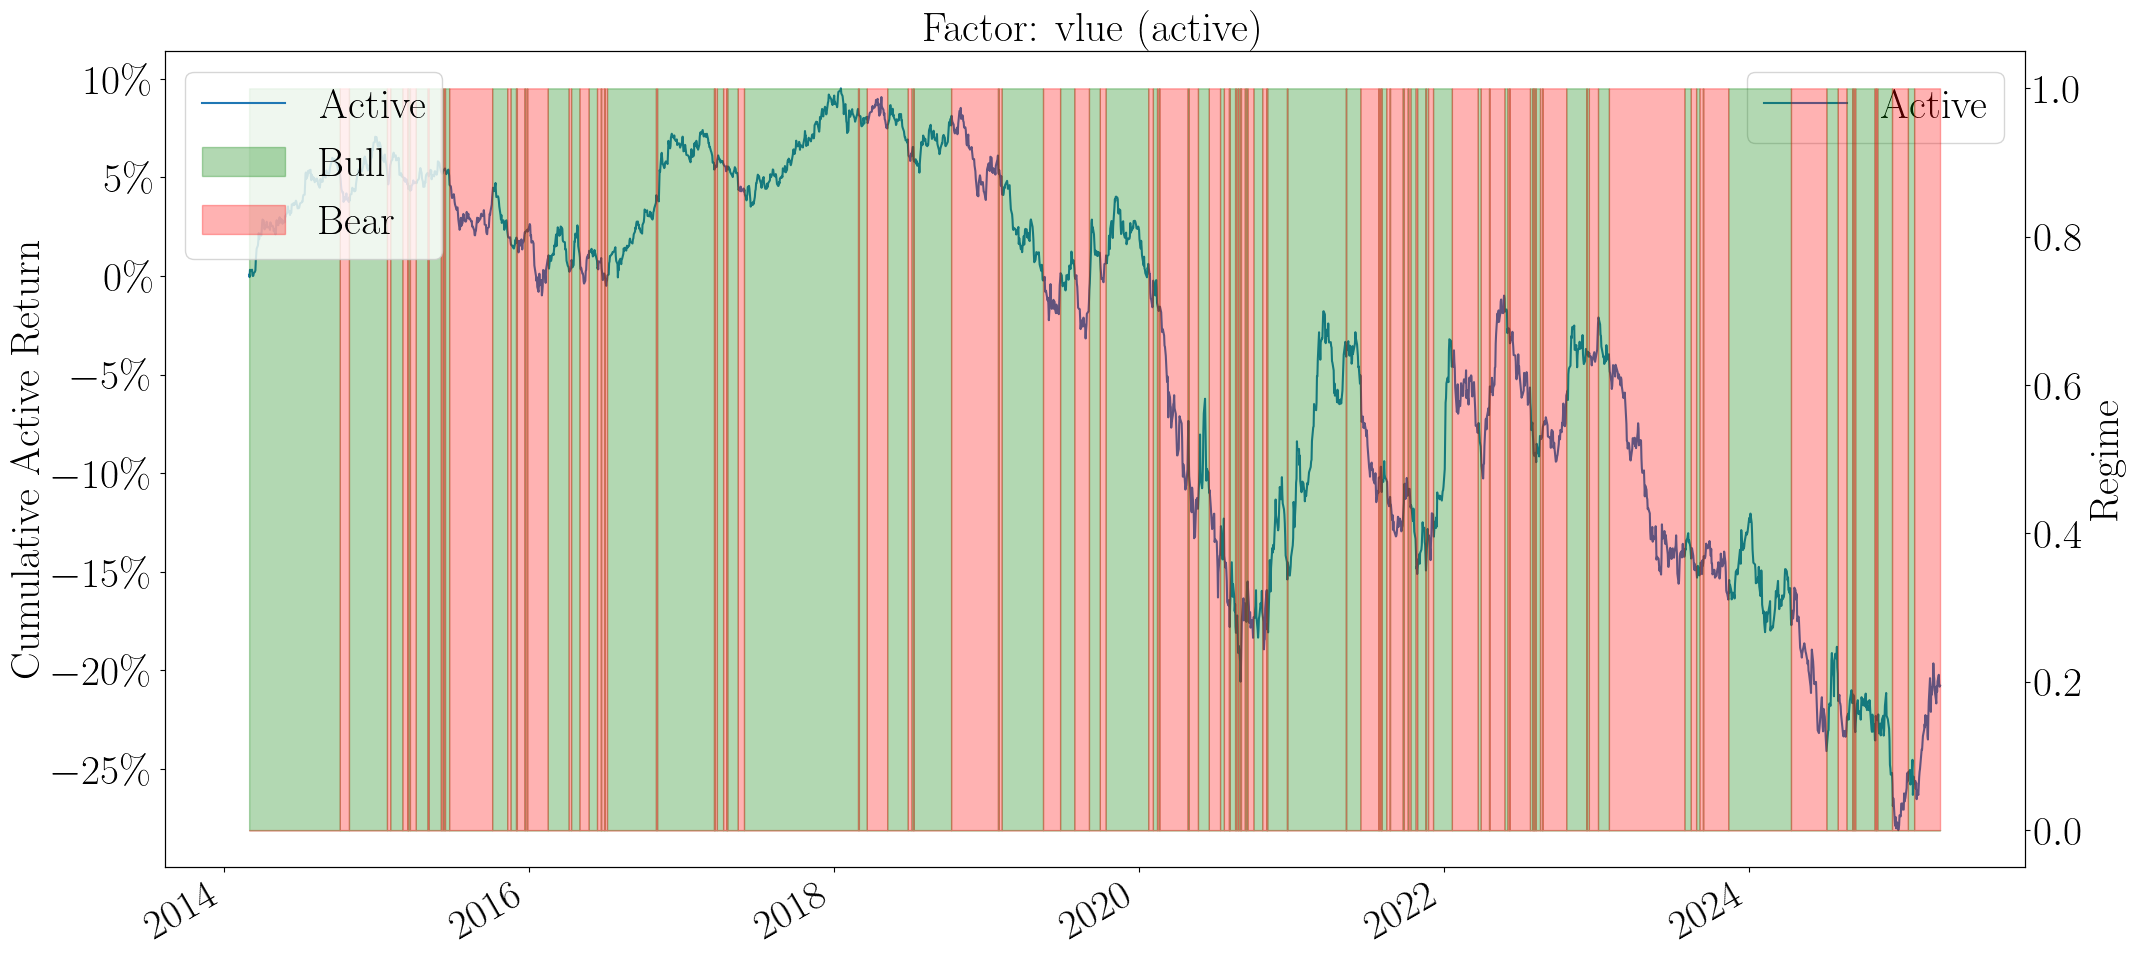

In [19]:
import matplotlib.pyplot as plt
from jumpmodels.plot import plot_regimes_and_cumret

for fac in factors:
    regimes     = factor_views[fac]["state"].dropna().astype(int)
    ret_raw     = factor_data_dict[fac]["fac_ret"].dropna()
    ret_active  = factor_data_dict[fac]["active_ret"].dropna()

    idx_raw    = regimes.index.intersection(ret_raw.index)
    idx_active = regimes.index.intersection(ret_active.index)

    # ---------- raw factor return ----------
    ax_raw, _ = plot_regimes_and_cumret(
        regimes.loc[idx_raw],
        ret_raw.loc[idx_raw],
        n_c=2,
        colors_regimes=['g','r'],
        labels_regimes=['Bull','Bear'],
        legend_loc='upper left'
    )
    ax_raw.set_title(f"Factor: {fac}")
    plt.show()

    # ---------- active return ----------
    ax_act, _ = plot_regimes_and_cumret(
        regimes.loc[idx_active],
        ret_active.loc[idx_active].to_frame("Active"),
        n_c=2,
        colors_regimes=['g','r'],
        labels_regimes=['Bull','Bear'],
        ylabel_ret="Cumulative Active Return",
        legend_loc='upper left'
    )
    ax_act.set_title(f"Factor: {fac} (active)")
    plt.show()

    
